# Graph Mini Project
#### Analysis of Social Networks and Email Communication Networks

**Authors:**
1. Alexandra Perruchot-Triboulet Rodríguez
2. Lucia Victoria Fernandez Sanchez

**Code:**
[link to GitHub repository](https://github.com/aleexx02/Graphs-mini-project.git)

# Objective

For this project, we have chosen 2 different graph datasets. For each of them we will:

**1.** Compute some preliminary statistics and perform analysis on the dataset using some centrality measures and relevant visualisations, including what each graph represents.

**2.** Compute/detect the communities on the dataset using at least 2 different detection community algorithms and different metrics to evaluate the quality of the communities.

# Datasets

## Dataset 1: Social Circles in Facebook

* **Source**: [Facebook dataset](https://snap.stanford.edu/data/ego-Facebook.html)

* **Description:**
This dataset contains 10 ego networks (friends list) from Facebook, where each ego network represents a person/entity (called the ego node), its immediate friends (local neighborhood), along with the connections among these friends if any. An edge (u, v) exists if users u and v are friends.

    For each ego network, there are 5 corresponding files:
    * `nodeId.edges`: contains the connections (edges) between friends within the ego network corresponding to the ego node identified by 'nodeId'. All nodes listed in this file are direct neighbours (friends) of the ego node. This edges do not involve the ego node; it only  considers the links between friends of the ego node.

    * `nodeId.circles`: contains the social circles or friend groups (user-defined communities) for the ego node 'nodeId'. Each line in this file represents one social circle, listing the node IDs of friends (nodes) that belong to that social circle.

    * `nodeId.feat`: contains the feature data for each friend in the ego network (those appearing in the edges file). Each row in this file corresponds to one node (friend) in the ego network.

    * `nodeId.egofeat`: contains feature data specific to the ego node 'nodeId'.

    * `nodeId.featnames`: contains the names/descriptions of the feature dimensions, where features are binary indicators: 1 if the user has the property and 0 otherwise.

    In short, every ego network represents the relationships between the friends of an ego node (not involving the ego node). 


*  **Dataset Statistics (from source):**
    * **Nodes**: 4039 facebook users.

    * **Edges**: 88234 friends relationships.
    
    * **Diameter (longest shortest path)**: 8.

    **`NOTE:`** these statistics were compiled by combining the ego-networks, including the ego nodes themselves (along with an edge to each of their friends).

* **Network Type:** UNDIRECTED graph.

* **Domain:** Social media (friendship connections).

## Dataset 2: Email Communication Network (European Research Institution)

* **Source**: [Email-Eu-Core dataset](https://snap.stanford.edu/data/email-Eu-core.html)

* **Description:**
This dataset represents email communication within a large European research institution. The network was generated using anonymized email data, capturing all incoming and outgoing emails between members of the institution.
An edge (u, v) exists in the network if person u sent person v at least one email. The emails only represent communication between institution members (the core), and the dataset does not contain incoming messages from or outgoing messages to the rest of the world.

    The dataset consists of just one file:
    * `email-Eu-core.txt`: contains the directed edges of the email network.

    Each line represents an email communication with the format: `source_node target_node`, where source_node sent at least one email to target_node.

*  **Dataset Statistics (from source):**
    * **Nodes**: 1005 members of a European research institution.

    * **Edges**: 25571 email communications.

    * **Diameter (longest shortest path)**: 7.

    **`NOTE:`** the diameter of 7 corresponds to the diameter of the largest weakly connected component (WCC) of the network.

* **Network Type:** DIRECTED graph.

* **Domain:** Email communication network (professional/institutional).

# Import Libraries

In [1]:
import requests
import tarfile
import gzip
import os
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import random
from scipy.sparse import issparse
from collections import Counter
import shutil
import community as community_louvain
from networkx.algorithms import community as nx_community
from itertools import combinations, islice
from scipy.cluster.hierarchy import linkage, fcluster
from networkx.algorithms.community import louvain_communities as nx_louvain
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.preprocessing import StandardScaler, normalize
import matplotlib.patches as mpatches
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, roc_auc_score, average_precision_score, roc_curve
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch_geometric.data import Data
# from torch_geometric.nn import GATConv
# from torch_geometric.transforms import RandomLinkSplit

# Paths

In [2]:
# Path where results will be saved
results_dir_facebook = "results/facebook/"
results_dir_email = "results/email/"

# Prepare datasets

### 1. Download datasets

To download both datasets, run the following code.

This will download: `'facebook.tar.gz'` and `'email-Eu-core.txt.gz'`, which are two .zip files corresponding to the Facebook and Email datasets, respectively.

In [3]:
# Download Facebook dataset (uncomment to download)
# url = 'https://snap.stanford.edu/data/facebook.tar.gz'
# response = requests.get(url)
# filename_1 = 'facebook.tar.gz'
# with open(filename_1, 'wb') as f:
#     f.write(response.content)

# print(f"Facebook dataset is downloaded successfully, saved as {filename_1}")


# Download Email dataset (uncomment to download)
# url = 'https://snap.stanford.edu/data/email-Eu-core.txt.gz'
# response = requests.get(url)
# filename_2 = 'email-Eu-core.txt.gz'
# with open(filename_2, 'wb') as f:
#     f.write(response.content)

# print(f"\nEmail dataset is downloaded successfully, saved as {filename_2}")

### 2. Extract data files

We extract both dataset files from their .tar.gz files and store them in `'facebook_data'` and `'email_data'` respectively.

In [4]:
# # Extract Facebook dataset
# os.makedirs('facebook_data', exist_ok=True) # Create the directory
# with tarfile.open('facebook.tar.gz', 'r:gz') as tar:
#     tar.extractall(path='facebook_data')
# # Move files from facebook_data/facebook/* to facebook_data/*
# inner_folder = os.path.join('facebook_data', 'facebook')
# for item in os.listdir(inner_folder):
#     shutil.move(os.path.join(inner_folder, item), 'facebook_data')
# os.rmdir(inner_folder) # Remove the now-empty facebook_data/facebook folder

# print("Facebook dataset was extracted successfully to 'facebook_data'.")



# # Extract Email dataset
# os.makedirs('email_data', exist_ok=True) # Create the directory
# with gzip.open('email-Eu-core.txt.gz', 'rb') as f_in, open('email_data/email-Eu-core.txt', 'wb') as f_out:
#     shutil.copyfileobj(f_in, f_out)

# print("\nEmail dataset was extracted successfully to 'email_data'.")

### 3. Check files of each dataset

In [5]:
# Files for facebook dataset
extracted_files_facebook = os.listdir('facebook_data')
print("Extracted files for Facebook dataset:\n", extracted_files_facebook)

# Files for email dataset
extracted_files_email = os.listdir('email_data')
print("\nExtracted files for Email dataset:\n", extracted_files_email)

Extracted files for Facebook dataset:
 ['0.circles', '0.edges', '0.egofeat', '0.feat', '0.featnames', '107.circles', '107.edges', '107.egofeat', '107.feat', '107.featnames', '1684.circles', '1684.edges', '1684.egofeat', '1684.feat', '1684.featnames', '1912.circles', '1912.edges', '1912.egofeat', '1912.feat', '1912.featnames', '3437.circles', '3437.edges', '3437.egofeat', '3437.feat', '3437.featnames', '348.circles', '348.edges', '348.egofeat', '348.feat', '348.featnames', '3980.circles', '3980.edges', '3980.egofeat', '3980.feat', '3980.featnames', '414.circles', '414.edges', '414.egofeat', '414.feat', '414.featnames', '686.circles', '686.edges', '686.egofeat', '686.feat', '686.featnames', '698.circles', '698.edges', '698.egofeat', '698.feat', '698.featnames']

Extracted files for Email dataset:
 ['email-Eu-core.txt']


# Preliminary statistics and analysis

In this section, we aim to compute some preliminary statistics and perform analysis on each dataset. For that, we will make use of some centrality measures (closeness, betweeness,...) and also build important visualisations.

We will start first with the Facebook dataset and then move on to the Email dataset.

### Facebook dataset

##### **1. Preview Dataset Structure**

The Facebook dataset consists of a total of 50 files, organized as 5 files per ego network for 10 ego networks.

Below is a preview of each type of file for the ego network corresponding to the ego node with ID = 0:

* `0.edges`: Lists the connections (edges) between friends within the ego network of node 0. These edges represent friendships among the friends of the ego node, not including the ego node itself.

* `0.circles`: Contains the friend groups (communities) in the ego network of node 0. Each line specifies one social circle and lists the node IDs of friends belonging to that circle.

* `0.feat`: Provides the feature data for each friend in the ego network of node 0. Each row corresponds to a friend node and encodes binary attributes reflecting their profile properties.

* `0.egofeat`: Contains only the feature data for the ego node 0 itself.

* `0.featnames`: Describes the names or categories of each feature dimension in the .feat and .egofeat files. These features have been anonymized but represent different user characteristics or profile attributes.

The **first line** of each of these files is provided below.

In [6]:
# Folder containing Facebook ego networks:
dataset_path = 'facebook_data'
# List of ego node IDs (from the file names):
ego_node_ids = ['0', '107', '348', '414', '686', '698', '1684', '1912', '3437', '3980']

# Preview first few lines of each file for ego node with ID = 0.
ego_id = '0'
for suffix in ['edges', 'circles', 'feat', 'egofeat', 'featnames']:
    filename = f"{ego_id}.{suffix}"
    filepath = os.path.join(dataset_path, filename)
    print("\n" + "="*70)
    print(f"File: '{filename}'")
    print('='*70)
    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            for i in range(1): # Print only the first line
                line = f.readline()
                if not line:
                    break
                print(f"  {line.strip()}")
    else:
        print("  (File not found)")


File: '0.edges'
  236 186

File: '0.circles'
  circle0	71	215	54	61	298	229	81	253	193	97	264	29	132	110	163	259	183	334	245	222

File: '0.feat'
  1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

File: '0.egofeat'
  0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0

##### **2. Load Facebook Network into NetworkX**

We begin by independently constructing each ego network and extracting its metrics (section 2.1). After, we combine these ego networks into a single aggregated graph to perform the same analyses for the whole network (section 2.2).

**2.1 Ego Networks**

**2.1.1 Build the ego networks**

**`NOTE:`** When constructing each ego network, we explicitly include the ego node itself along with edges connecting this ego node to all its friends. This is necessary because the `.edges` file only considers connections among friends and does not include edges between the ego node and its friends.

In [7]:
# Dictionary to store each ego network graph
ego_graphs = {}
summary = [] # rows for summary table

for ego_id in ego_node_ids:
    edges_file = os.path.join(dataset_path, f"{ego_id}.edges")
    circles_file = os.path.join(dataset_path, f"{ego_id}.circles")
    feat_file = os.path.join(dataset_path, f"{ego_id}.feat")
    
    # Create graph for this ego network
    G = nx.Graph() # undirected graph

    G.add_node(int(ego_id)) # Add ego node
    # Load edges from ego node to friends (from feat file):
    friend_count = 0
    if os.path.exists(feat_file):
        with open(feat_file) as f:
            for line_num, line in enumerate(f, 1):
                # each line of the feat file corresponds to a friend node of the ego node
                friend_id = line.strip().split()[0] # first column is the friend node ID
                G.add_edge(int(ego_id), int(friend_id))
                friend_count += 1

    # Load friend edges (from edges file):
    num_edges = 0
    if os.path.exists(edges_file):
        with open(edges_file) as f:
            for line in f:
                u, v = line.strip().split()
                G.add_edge(int(u), int(v))
                num_edges += 1
    
    # Store the graph in the dictionary
    ego_graphs[ego_id] = G
    
    # Get graph stats
    num_nodes = G.number_of_nodes()
    
    # Count circles/communities
    num_circles = 0
    if os.path.exists(circles_file):
        with open(circles_file) as f:
            num_circles = sum(1 for _ in f)

    
    summary.append({
        'Ego ID': ego_id,
        'Nodes': num_nodes,
        'Edges': num_edges,
        'Friends': friend_count,
        'Diameter': nx.diameter(G) if nx.is_connected(G) else 'N/A',
        'Density': nx.density(G),
        'Avg. Degree of Nodes': sum(dict(G.degree()).values()) / num_nodes if num_nodes > 0 else 0,
        'Avg. Clustering Coeff.': nx.average_clustering(G),
        'No. of Connected Components': nx.number_connected_components(G),
        'No. Communities': num_circles,
    })

    print(f"\nEgo Network ID: {ego_id} loaded successfully!")


Ego Network ID: 0 loaded successfully!

Ego Network ID: 107 loaded successfully!

Ego Network ID: 348 loaded successfully!

Ego Network ID: 414 loaded successfully!

Ego Network ID: 686 loaded successfully!

Ego Network ID: 698 loaded successfully!

Ego Network ID: 1684 loaded successfully!

Ego Network ID: 1912 loaded successfully!

Ego Network ID: 3437 loaded successfully!

Ego Network ID: 3980 loaded successfully!


**2.1.2 Summary table of each ego network**

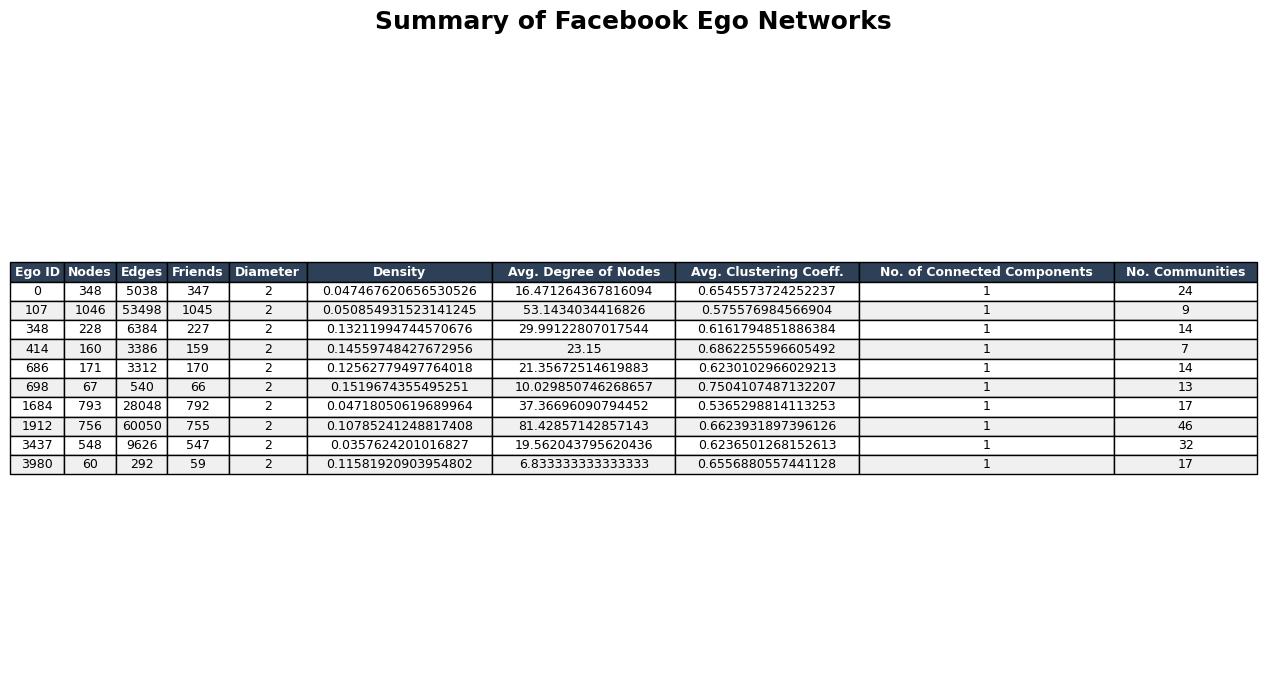


Summary table saved successfully as 'results/facebook/Ego-Networks/FacebookEgoNetworks_summary_table.png'


In [10]:
# function to save summary table as image
def save_table_as_image(df, title, filename, fontsize=9):
    fig, ax = plt.subplots(figsize=(14, len(df) * 0.6 + 1))
    ax.axis('off')

    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(fontsize)
    table.auto_set_column_width(col=list(range(len(df.columns))))

    for j in range(len(df.columns)):
        table[0, j].set_facecolor('#2E4057')
        table[0, j].set_text_props(color='white', fontweight='bold')

    for i in range(1, len(df) + 1):
        for j in range(len(df.columns)):
            table[i, j].set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')

    plt.title(title, fontsize=18, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nSummary table saved successfully as '{filename}'")


# Summary table of each ego network:
df_summary = pd.DataFrame(summary)

save_table_as_image(df_summary, title='Summary of Facebook Ego Networks',
                    filename = f'{results_dir_facebook}Ego-Networks/FacebookEgoNetworks_summary_table.png')


**2.1.3 Visualization of each ego network**

**`NOTE:`** Since some ego networks have a large number of nodes, visualizing the entire network can result in a cluttered and unclear diagram. To improve clarity, when the number of nodes in the network exceeds a specified threshold (*max_nodes*), the visualization function selects only the first *max_nodes* nodes (corresponding to a subset of the network) and creates a subgraph based on these nodes. This sampling reduces visual complexity, making the diagram easier to interpret while still representing the network structure.

For each ego network visualization, nodes are colored as follows:
* **Purple**: the ego node.
* **Red**: nodes with very high degree centrality: $ degree \geq 0.15$.
* **Orange**: nodes with high degree centrality: $ 0.10 \leq degree < 0.15$.
* **Yellow**: nodes with medium degree centrality: $ 0.05 \leq degree < 0.10$.
* **Light blue**: all other nodes (with low degree): $degree < 0.05$.

In [133]:
# Function to plot an ego network
def plot_ego_networks(G, ego_id, max_nodes = 150, node_size=30, font_size=9, save_path = None):
    plt.figure(figsize=(12, 10))

    if G.number_of_nodes() > max_nodes:
        nodes_sample = list(G.nodes())[:max_nodes]
        G_sample = G.subgraph(nodes_sample).copy()
    else:
        G_sample = G
    
    pos = nx.kamada_kawai_layout(G_sample, dist=None)

    # Calculate node sizes based on degree centrality
    degree_centrality = nx.degree_centrality(G_sample)

    node_sizes = [degree_centrality[node] * 1400 + node_size for node in G_sample.nodes()]
    
    # Color nodes: Ego node red, high degree nodes in orange, others blue
    ego_node = ego_id
    node_colors = []
    for node in G_sample.nodes():
        if node == ego_node:
            node_colors.append('purple')  # Ego node
        elif degree_centrality[node] >= 0.15:
            node_colors.append('red')  # Very high degree
        elif degree_centrality[node] >= 0.10:
            node_colors.append('orange')      # High degree
        elif degree_centrality[node] >= 0.05:
            node_colors.append('yellow')     # Medium degree
        else:
            node_colors.append('lightblue')   # Low degree
    
    # Draw nodes:
    nx.draw_networkx_nodes(G_sample, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)
    # Draw edges:
    nx.draw_networkx_edges(G_sample, pos, alpha=0.5, edge_color='black')
    
    # Label all nodes with their IDs
    labels = {node: str(node) for node in G_sample.nodes()}
    nx.draw_networkx_labels(G_sample, pos, labels=labels, font_size=font_size, font_weight='bold')

    # Add legend for node colors
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', 
                   markersize=12, label='Ego Node'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                   markersize=12, label='Very High Degree (≥ 0.15)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', 
                   markersize=12, label='High Degree (0.10 ≤ degree < 0.15)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', 
                   markersize=12, label='Medium Degree (0.05 ≤ degree < 0.10)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', 
                   markersize=12, label='Low Degree (< 0.05)')
    ]
    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))

    plt.axis('off')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Graph visualization for Ego ID {ego_id} saved successfully!")
        print(f"Path: {save_path}")
        plt.close()


# plot ego networks
for ego_id, G in ego_graphs.items():
    print("\n" + "="*60)
    print(f"EGO NETWORK VISUALIZATION | Ego ID: {ego_id} ")
    print("="*60)
    plot_ego_networks(G, ego_id, save_path=f"{results_dir_facebook}Ego-Networks/ego_network_{ego_id}.png")


EGO NETWORK VISUALIZATION | Ego ID: 0 
Graph visualization for Ego ID 0 saved successfully!
Path: results/facebook/Ego-Networks/ego_network_0.png

EGO NETWORK VISUALIZATION | Ego ID: 107 
Graph visualization for Ego ID 107 saved successfully!
Path: results/facebook/Ego-Networks/ego_network_107.png

EGO NETWORK VISUALIZATION | Ego ID: 348 
Graph visualization for Ego ID 348 saved successfully!
Path: results/facebook/Ego-Networks/ego_network_348.png

EGO NETWORK VISUALIZATION | Ego ID: 414 
Graph visualization for Ego ID 414 saved successfully!
Path: results/facebook/Ego-Networks/ego_network_414.png

EGO NETWORK VISUALIZATION | Ego ID: 686 
Graph visualization for Ego ID 686 saved successfully!
Path: results/facebook/Ego-Networks/ego_network_686.png

EGO NETWORK VISUALIZATION | Ego ID: 698 
Graph visualization for Ego ID 698 saved successfully!
Path: results/facebook/Ego-Networks/ego_network_698.png

EGO NETWORK VISUALIZATION | Ego ID: 1684 
Graph visualization for Ego ID 1684 saved suc

**2.1.4 Centrality measures of each ego network**

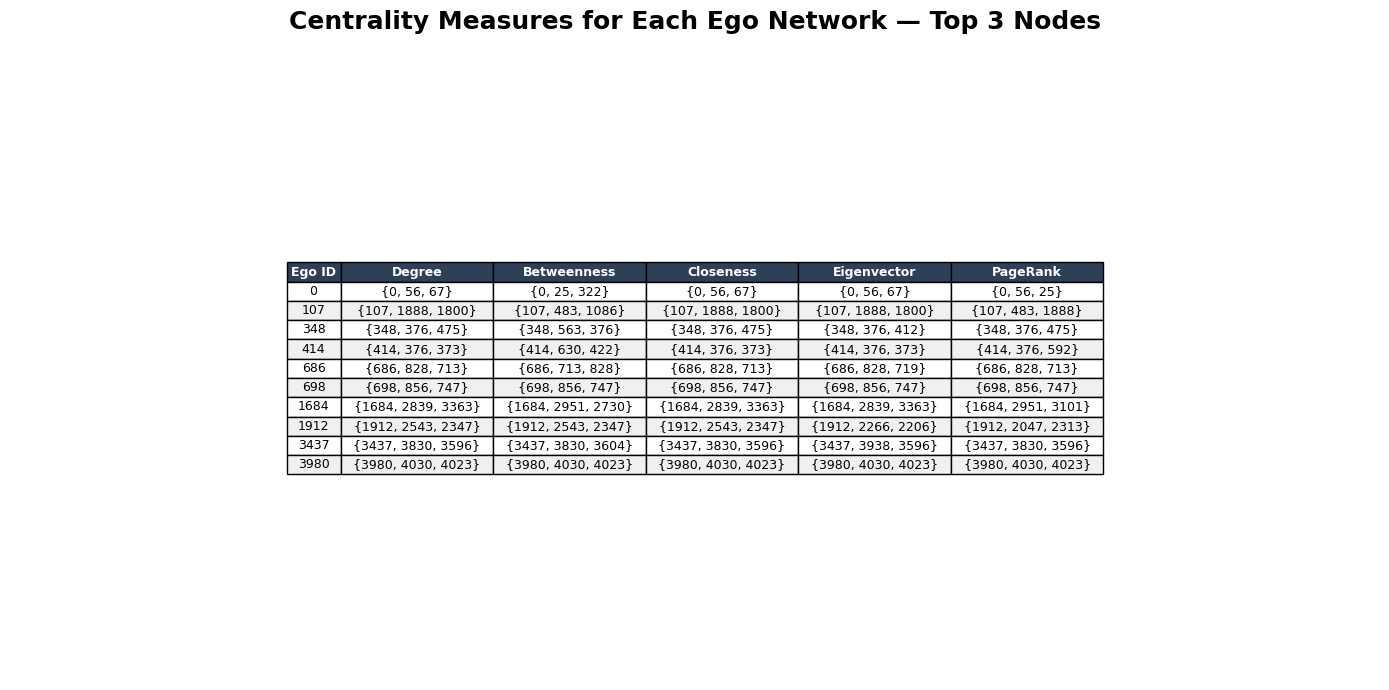


Summary table saved successfully as 'results/facebook/Ego-Networks/centralityMeasures_summary_FacebookEgoNetworks.png'


In [ ]:
# CENTRALITY MEASURES
# List of centralities to compute
centrality_functions = {
    'Degree': nx.degree_centrality,
    'Betweenness': nx.betweenness_centrality,
    'Closeness': nx.closeness_centrality,
    'Eigenvector': lambda G: nx.eigenvector_centrality(G, max_iter=1000),
    'PageRank': nx.pagerank
}


summary_rows = []
# For each ego network, compute centrality measures and get top 3 nodes
for ego_id, G in ego_graphs.items():
    row = {'Ego ID': ego_id}
    for name, func in centrality_functions.items():
        centrality_scores = func(G)
        top3_nodes = sorted(centrality_scores.items(), key=lambda x: x[1], reverse=True)[:3]
        formatted_top3 = ', '.join(str(node) for node, _ in top3_nodes)
        row[name] = f"{{{formatted_top3}}}"
    summary_rows.append(row)


# Table of centrality measures summary for each ego network:
df_centrality_summary = pd.DataFrame(summary_rows)
save_table_as_image(df_centrality_summary, title='Centrality Measures for Each Ego Network — Top 3 Nodes',
    filename = f'{results_dir_facebook}Ego-Networks/centralityMeasures_summary_FacebookEgoNetworks.png')

**2.2 Whole Network**

**2.2.1 Build whole (global) graph, combining all the ego networks.**

In [8]:
# Create a whole graph summary table:
facebook_network = nx.Graph() # undirected graph

for ego_id, G in ego_graphs.items():
    facebook_network.add_nodes_from(G.nodes())
    facebook_network.add_edges_from(G.edges())

print("\n Full Facebook Network loaded successfully!")



 Full Facebook Network loaded successfully!


**2.2.2 Summary table of the whole (global) graph**

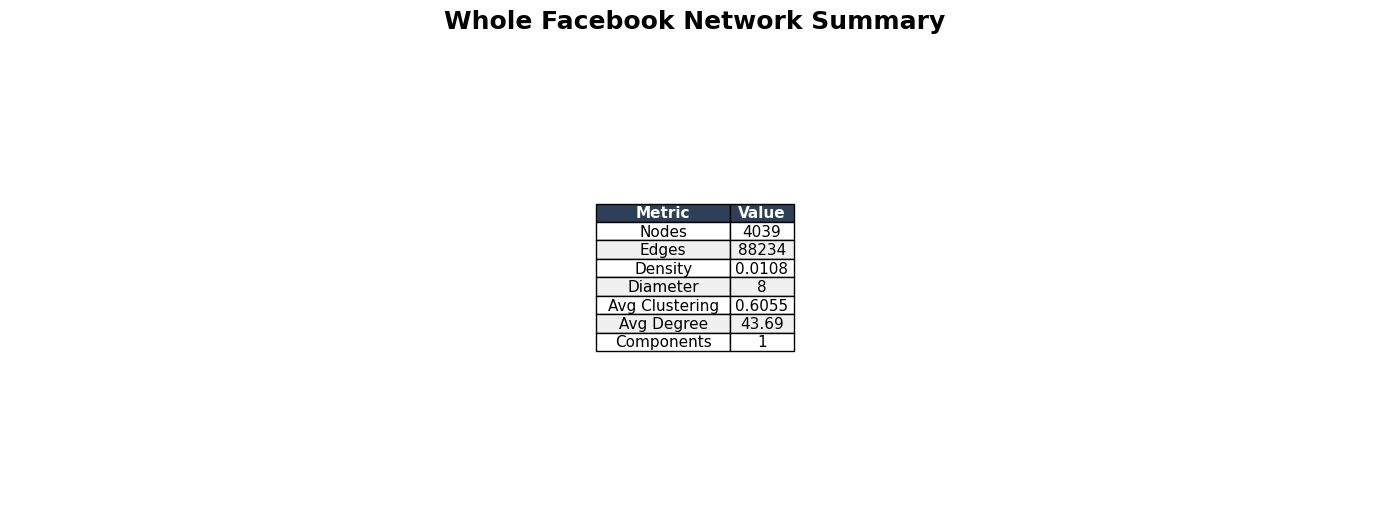


Summary table saved successfully as 'results/facebook/Whole_facebook_network_summary.png'


In [11]:
# GLOBAL GRAPH SUMMARY TABLE
whole_graph_summary = []
global_stats = {
    'Metric': ['Nodes', 'Edges', 'Density', 'Diameter', 'Avg Clustering', 'Avg Degree', 'Components'],
    'Value': [
        f"{facebook_network.number_of_nodes():.0f}",
        f"{facebook_network.number_of_edges():.0f}",
        f"{nx.density(facebook_network):.4f}",
        f"{nx.diameter(facebook_network):.0f}" if nx.is_connected(facebook_network) else 'NaN',
        f"{nx.average_clustering(facebook_network):.4f}",
        f"{sum(dict(facebook_network.degree()).values()) / facebook_network.number_of_nodes():.2f}",
        f"{nx.number_connected_components(facebook_network):.0f}"
    ]
}


df_global_stats = pd.DataFrame(global_stats)

save_table_as_image(df_global_stats, title='Whole Facebook Network Summary',
                    filename=f'{results_dir_facebook}Whole_facebook_network_summary.png', fontsize=11)

**2.2.3 Visualization of the whole (global) graph**

**`NOTE:`** Just as for the ego networks, since the global graph has a large number of nodes, visualizing the entire network can result in a cluttered and unclear diagram. To improve clarity, the visualization function select the first *max_nodes* nodes (corresponding to a subset of the network) and creates a subgraph based on these nodes. This sampling reduces visual complexity, making the diagram easier to interpret while still representing the network structure.

For the network visualization, nodes are colored as follows:
* **Purple**: the ego nodes.
* **Red**: nodes with the highest degree centrality: $ degree \geq 0.15$.
* **Orange**: nodes with very high degree centrality: $ 0.10 \leq degree < 0.15$.
* **Yellow**: nodes with high degree centrality: $ 0.05 \leq degree < 0.10$.
* **Light green**: nodes with medium degree centrality: $ 0.01 \leq degree < 0.05$.
* **Light blue**: all other nodes (with low degree): $degree < 0.01$.

In [ ]:
# Function to plot the whole network
def plot_whole_network(global_graph, ego_nodes, max_nodes=600, node_size = 30, font_size=7, save_path = None):

    nodes = list(global_graph.nodes())[:max_nodes]

    G_sample = global_graph.subgraph(nodes).copy()
    
    plt.figure(figsize=(14, 12))
    pos = nx.kamada_kawai_layout(G_sample, scale=2500)

    degree_centrality = nx.degree_centrality(G_sample)
    
    node_sizes = [degree_centrality[node] * 1000 + node_size for node in G_sample.nodes()]

    node_colors = []
    for node in G_sample.nodes():
        if node in ego_nodes:
            node_colors.append('purple')  # Ego nodes in purple
        elif degree_centrality[node] >= 0.15:
            node_colors.append('red')    # Highest degree
        elif degree_centrality[node] >= 0.10:
            node_colors.append('orange')  # Very high degree  
        elif degree_centrality[node] >= 0.05:
            node_colors.append('yellow')  # High degree
        elif degree_centrality[node] >= 0.01:
            node_colors.append('lightgreen')   # Medium degree
        else:
            node_colors.append('lightblue')  # Lowest degree

    nx.draw_networkx_nodes(G_sample, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(G_sample, pos, alpha=0.3, edge_color='gray')
    
    # Label all nodes with their IDs
    labels = {node: str(node) for node in G_sample.nodes()}
    nx.draw_networkx_labels(G_sample, pos, labels=labels, font_size=font_size, font_weight='bold')

    # Legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=12, label='Ego Nodes'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=12, label='Highest Degree (≥ 0.15)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=12, label='Very High Degree (0.10 ≤ degree < 0.15)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=12, label='High Degree (0.05 ≤ degree < 0.10)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=12, label='Medium Degree (0.01 ≤ degree < 0.05)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=12, label='Lowest Degree (degree < 0.01)'),
    ]
    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))
    print("\n" + "="*100)
    print(f"SAMPLE OF FACEBOOK NETWORK VISUALIZATION - {max_nodes} nodes")
    print("="*100)
    plt.axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Graph visualization for sample of Facebook Network saved successfully!")
        print(f"Path: {save_path}")
        plt.close()


# Plot sample of the network:
plot_whole_network(facebook_network, ego_node_ids, save_path=f'{results_dir_facebook}facebook_network_visualization.png')


SAMPLE OF FACEBOOK NETWORK VISUALIZATION - 600 nodes
Graph visualization for sample of Facebook Network saved successfully!
Path: results/facebook/facebook_network_visualization.png


**2.2.4 Centrality measures of the whole (global) graph**

In [ ]:
# CENTRALITY MEASURES - One table per measure (Top 5)
centralities = {}

# 1. Degree Centrality
centralities['Degree'] = nx.degree_centrality(facebook_network)

# 2. Betweenness Centrality
centralities['Betweenness'] = nx.betweenness_centrality(facebook_network)

# 3. Closeness Centrality
centralities['Closeness'] = nx.closeness_centrality(facebook_network)

# 4. Eigenvector Centrality
centralities['Eigenvector'] = nx.eigenvector_centrality(facebook_network, max_iter=1000)

# 5. PageRank
centralities['PageRank'] = nx.pagerank(facebook_network)


# Function to extract top 5 for each measure:
def top5_nodes(centrality_dict):
    top5 = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:5]
    
    table_data = []
    for node, score in top5:
        table_data.append({'Node': node, 'Score': f"{score:.6f}"})
    
    df_top5 = pd.DataFrame(table_data)
    return df_top5

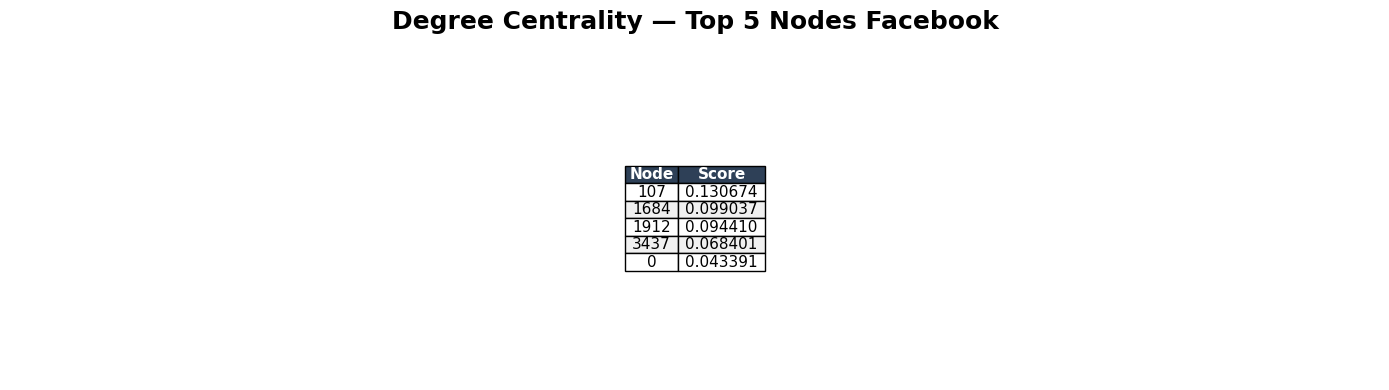


Summary table saved successfully as 'results/facebook/Centrality Metrics/Top5centrality_degree_FacebookNetwork.png'


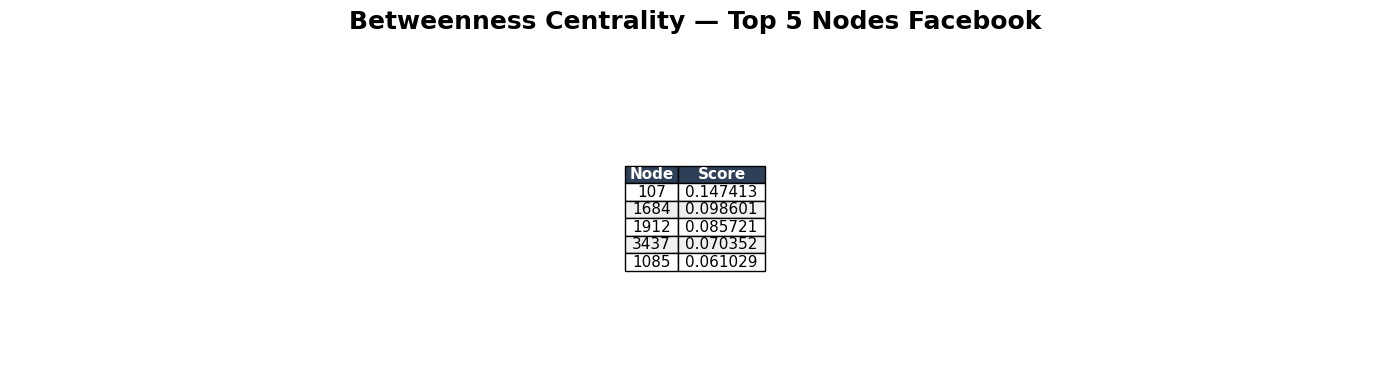


Summary table saved successfully as 'results/facebook/Centrality Metrics/Top5centrality_betweenness_FacebookNetwork.png'


In [ ]:
# Degree centrality table:
df_degree_top5 = top5_nodes(centralities['Degree'])
save_table_as_image(df_degree_top5, 'Degree Centrality — Top 5 Nodes Facebook',
        f'{results_dir_facebook}Centrality Metrics/Top5centrality_degree_FacebookNetwork.png', fontsize = 11)


# Betweeness centrality table:
df_betweenness_top5 = top5_nodes(centralities['Betweenness'])
save_table_as_image(df_betweenness_top5, 'Betweenness Centrality — Top 5 Nodes Facebook', 
        f'{results_dir_facebook}Centrality Metrics/Top5centrality_betweenness_FacebookNetwork.png', fontsize = 11)

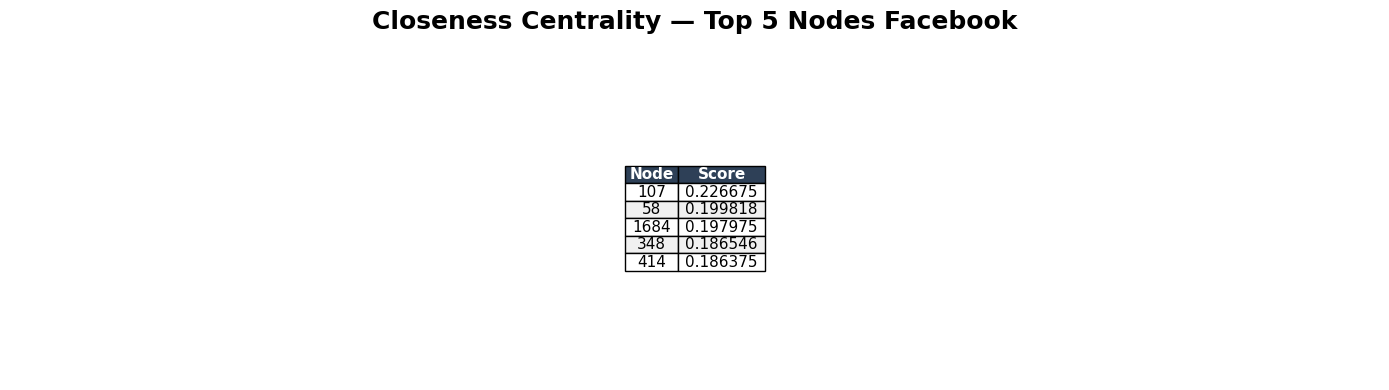


Summary table saved successfully as 'results/facebook/Centrality Metrics/Top5centrality_closeness_FacebookNetwork.png'


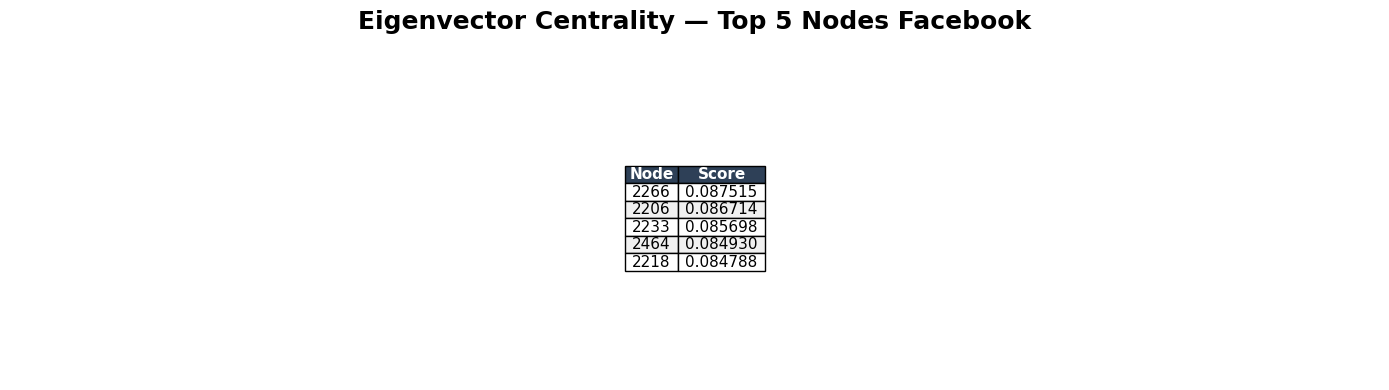


Summary table saved successfully as 'results/facebook/Centrality Metrics/Top5centrality_eigenvector_FacebookNetwork.png'


In [ ]:
# Closeness centrality table:
closeness_top5 = top5_nodes(centralities['Closeness'])
save_table_as_image(closeness_top5, 'Closeness Centrality — Top 5 Nodes Facebook', 
    f'{results_dir_facebook}Centrality Metrics/Top5centrality_closeness_FacebookNetwork.png', fontsize = 11)

# Eigenvector centrality table:
eigenvector_top5 = top5_nodes(centralities['Eigenvector'])
save_table_as_image(eigenvector_top5, 'Eigenvector Centrality — Top 5 Nodes Facebook', 
    f'{results_dir_facebook}Centrality Metrics/Top5centrality_eigenvector_FacebookNetwork.png', fontsize = 11)

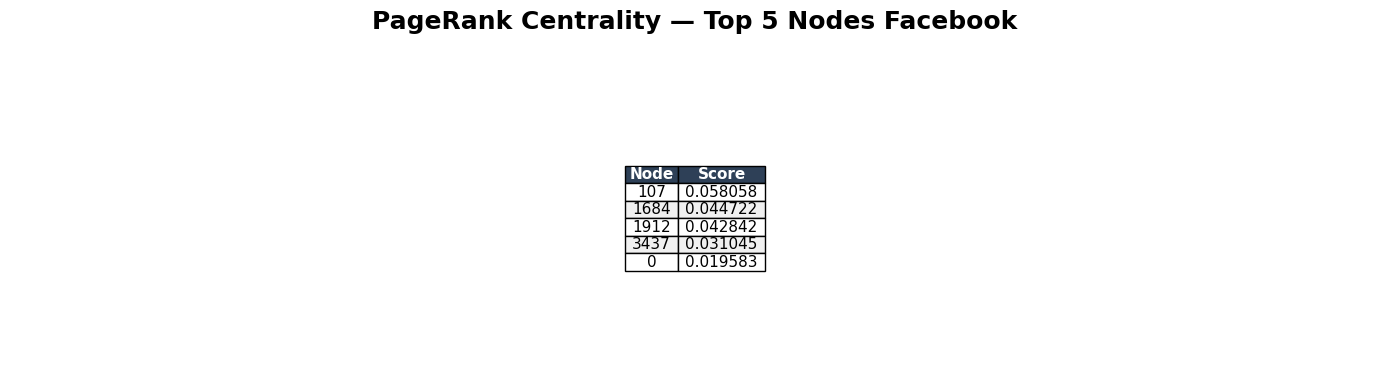


Summary table saved successfully as 'results/facebook/Centrality Metrics/Top5centrality_pagerank_FacebookNetwork.png'


In [ ]:
# PageRank centrality table:
pagerank_top5 = top5_nodes(centralities['PageRank'])
save_table_as_image(pagerank_top5, 'PageRank Centrality — Top 5 Nodes Facebook', 
        f'{results_dir_facebook}Centrality Metrics/Top5centrality_pagerank_FacebookNetwork.png', fontsize = 11)

### Email dataset

##### **1. Preview Dataset Structure**

The Email dataset consists of one file: `email-Eu-core.txt`.

This contains the directed edges of the email network. Each line of this file represents an email communication represented as: `source_node target_node`, where source_node sent at least one email to target_node.

In [116]:
email_txt_file = 'email_data/email-Eu-core.txt'

# Preview the first few lines of the dataset
print("\n" + "="*50)
print("    First 3 lines of the email-Eu-core dataset:")
print("="*50)
with open(email_txt_file, 'r') as f:
    for i, line in enumerate(f):
        if i < 3:
            print(line.strip())
        else:
            break

print("\nFORMAT: Each line represents an edge (source_node -> target_node)")
print("\nThe network is DIRECTED (u -> v means u sent email to v)")


    First 3 lines of the email-Eu-core dataset:
0 1
2 3
2 4

FORMAT: Each line represents an edge (source_node -> target_node)

The network is DIRECTED (u -> v means u sent email to v)


##### **2. Load Email Network into NetworkX**

In [117]:
# Load the email network as a directed graph
email_network = nx.DiGraph()

with open(email_txt_file, 'r') as f:
    for line in f:
        source, target = line.strip().split()
        email_network.add_edge(int(source), int(target))

print(f"\nEmail network loaded successfully!")


Email network loaded successfully!


##### **3. Summary Table of Email Network**


Summary tables ready!


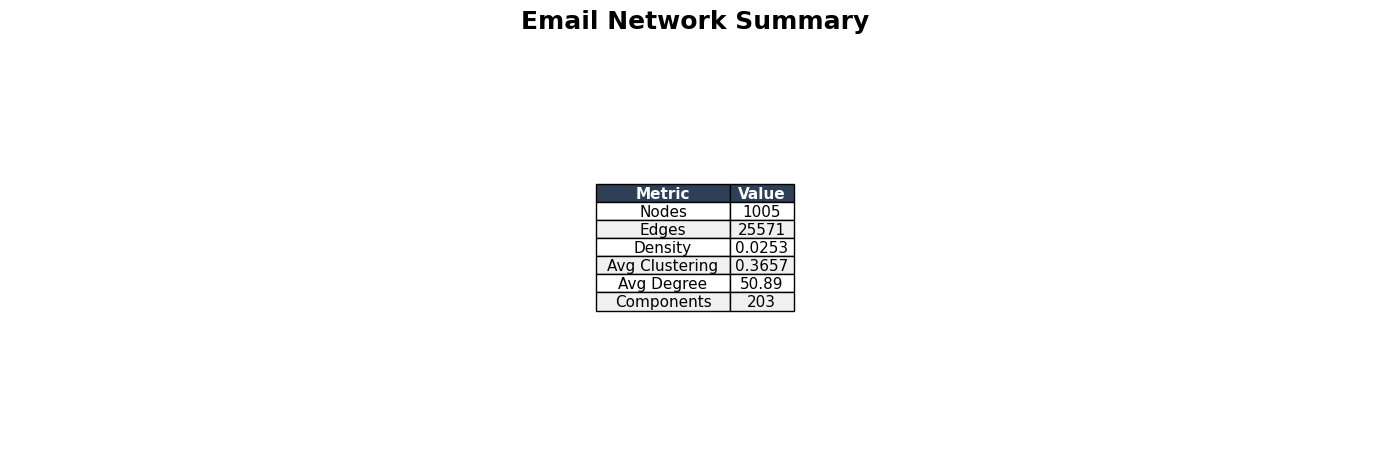


Summary table saved successfully as 'results/email/email_network_summary.png'


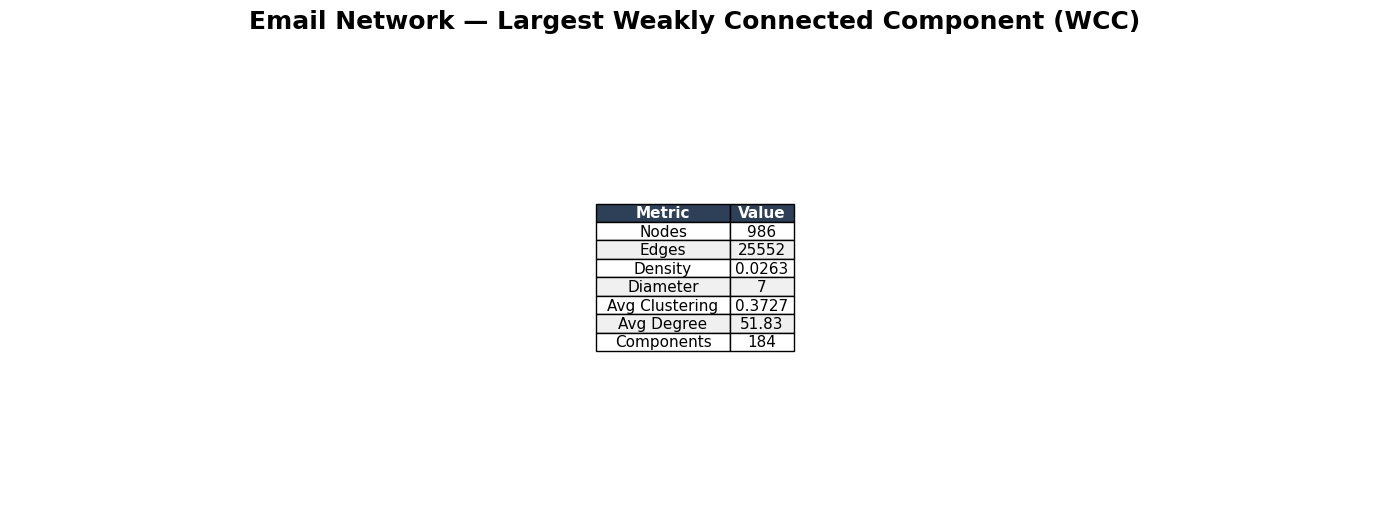


Summary table saved successfully as 'results/email/email_network_wcc_summary.png'


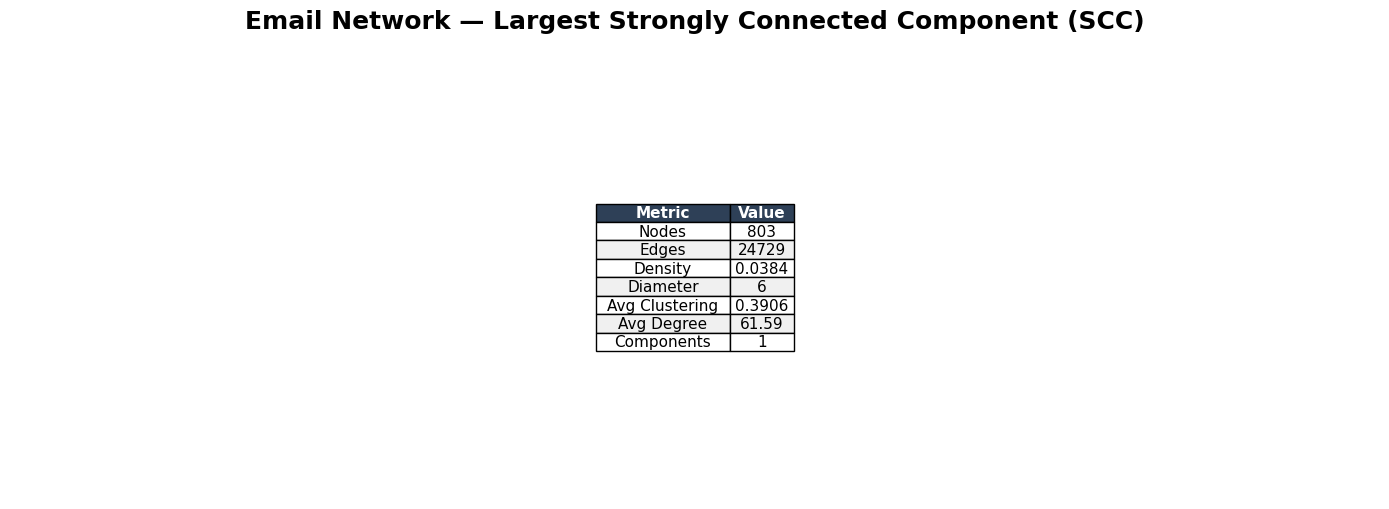


Summary table saved successfully as 'results/email/email_network_scc_summary.png'


In [ ]:
# GLOBAL GRAPH SUMMARY TABLE

# Obtain largest weakly connected component (WCC)
wccs = list(nx.weakly_connected_components(email_network))
largest_wcc = max(wccs, key=len)
G_largest_wcc = email_network.subgraph(largest_wcc).copy()
wcc_diameter = nx.diameter(G_largest_wcc.to_undirected())

# Obtain largest strongly connected component (SCC)
sccs = list(nx.strongly_connected_components(email_network))
largest_scc = max(sccs, key=len)
G_largest_scc = email_network.subgraph(largest_scc).copy()
scc_diameter = nx.diameter(G_largest_scc) if len(largest_scc) > 1 else 0

# Summary table of whole network
stats_network = {
    'Metric': ['Nodes', 'Edges', 'Density', 'Avg Clustering', 'Avg Degree', 'Components'],
    'Value': [
        f"{email_network.number_of_nodes():.0f}",
        f"{email_network.number_of_edges():.0f}",
        f"{nx.density(email_network):.4f}",
        f"{nx.average_clustering(email_network):.4f}",
        f"{sum(dict(email_network.degree()).values()) / email_network.number_of_nodes():.2f}",
        f"{nx.number_strongly_connected_components(email_network):.0f}"
    ]
}

# Summary table of largest WCC
stats_wcc = {
    'Metric': ['Nodes', 'Edges', 'Density', 'Diameter', 'Avg Clustering', 'Avg Degree', 'Components'],
    'Value': [
        f"{G_largest_wcc.number_of_nodes():.0f}",
        f"{G_largest_wcc.number_of_edges():.0f}",
        f"{nx.density(G_largest_wcc):.4f}",
        f"{wcc_diameter:.0f}",
        f"{nx.average_clustering(G_largest_wcc):.4f}",
        f"{sum(dict(G_largest_wcc.degree()).values()) / G_largest_wcc.number_of_nodes():.2f}",
        f"{nx.number_strongly_connected_components(G_largest_wcc):.0f}"
    ]
}


# Summary table of largest SCC
stats_scc = {
    'Metric': ['Nodes', 'Edges', 'Density', 'Diameter', 'Avg Clustering', 'Avg Degree', 'Components'],
    'Value': [
        f"{G_largest_scc.number_of_nodes():.0f}",
        f"{G_largest_scc.number_of_edges():.0f}",
        f"{nx.density(G_largest_scc):.4f}",
        f"{scc_diameter:.0f}",
        f"{nx.average_clustering(G_largest_scc):.4f}",
        f"{sum(dict(G_largest_scc.degree()).values()) / G_largest_scc.number_of_nodes():.2f}",
        f"{nx.number_strongly_connected_components(G_largest_scc):.0f}"
    ]
}

print("\nSummary tables ready!")

save_table_as_image(pd.DataFrame(stats_network), title='Email Network Summary',
    filename = f'{results_dir_email}email_network_summary.png', fontsize=11)

save_table_as_image(pd.DataFrame(stats_wcc), title='Email Network — Largest Weakly Connected Component (WCC)',
    filename = f'{results_dir_email}email_network_wcc_summary.png', fontsize=11)

save_table_as_image(pd.DataFrame(stats_scc), title='Email Network — Largest Strongly Connected Component (SCC)',
    filename = f'{results_dir_email}email_network_scc_summary.png', fontsize=11)

##### **4. Visualization of the Email Network**

With 1005 nodes, plotting the full email network creates visual clutter from overlapping nodes, edge crossings, and unreadable labels, hiding key patterns. For this reason, the visualization function select the first *max_nodes* nodes (corresponding to a subset of the network) and creates a subgraph based on these nodes. This sampling reduces visual complexity, making the diagram easier to interpret while still representing the network structure.

For the network visualization, nodes are colored as follows:
* **Dark blue**: nodes with the highest degree centrality: $ degree \geq 0.65$.
* **Purple**: nodes with degree centrality such that: $ 0.50 \leq degree < 0.65$
* **Red**: nodes with degree centrality such that: $ 0.35 \leq degree < 0.50$.
* **Orange**: nodes with degree centrality such that: $ 0.20 \leq degree < 0.35$.
* **Yellow**: nodes with degree centrality such that: $ 0.10 \leq degree < 0.20$.
* **Light blue**: all other nodes (with low degree): $degree < 0.10$.

In [ ]:
# Function to plot the network
def plot_network(global_graph, max_nodes=100, node_size = 30, font_size=7, save_path = None):
    
    nodes = list(global_graph.nodes())[:max_nodes]
    
    G_sample = global_graph.subgraph(nodes).copy()
    
    plt.figure(figsize=(14, 12))
    
    pos = nx.kamada_kawai_layout(G_sample, scale=15)
    degree_centrality = nx.degree_centrality(G_sample)
    
    node_sizes = node_sizes = [degree_centrality[node] * 800 + node_size for node in G_sample.nodes()]
    
    node_colors = []
    for node in G_sample.nodes():
        deg_cent = degree_centrality[node]
        if deg_cent >= 0.65:
            node_colors.append('darkblue')
        elif deg_cent >= 0.50:
            node_colors.append('purple')
        elif deg_cent >= 0.35:
            node_colors.append('red')
        elif deg_cent >= 0.20:
            node_colors.append('orange')
        elif deg_cent >= 0.10:
            node_colors.append('yellow')
        else:
            node_colors.append('lightblue')
    
    nx.draw_networkx_nodes(G_sample, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(G_sample, pos, alpha=0.3, edge_color='gray')
    
    labels = {node: str(node) for node in G_sample.nodes()}
    nx.draw_networkx_labels(G_sample, pos, labels=labels, font_size=font_size, font_weight='bold')
    
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkblue', markersize=12, label='Highest Degree (≥ 0.65)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=12, label='0.50 ≤ degree < 0.65'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=12, label='0.35 ≤ degree < 0.50'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=12, label='0.20 ≤ degree < 0.35'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=12, label='0.10 ≤ degree < 0.20'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=12, label='degree < 0.10'),
    ]
    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))
    print("\n" + "="*100)
    print(f"SAMPLE OF EMAIL NETWORK VISUALIZATION - {max_nodes} nodes")
    print("="*100)
    plt.axis('off')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Graph visualization for sample of Email Network saved successfully!")
        print(f"Path: {save_path}")
        plt.close()
    

# Call the function to plot the sample for network:
plot_network(email_network, max_nodes=100, save_path = f"{results_dir_email}email_network_visualization.png")



SAMPLE OF EMAIL NETWORK VISUALIZATION - 100 nodes
Graph visualization for sample of Email Network saved successfully!
Path: results/email/email_network_visualization.png


##### **5. Centrality measures of the Email Network**

In [ ]:
# CENTRALITY MEASURES - One table per measure (Top 5)
centralities = {}

# 1. Degree Centrality
centralities['Degree'] = nx.degree_centrality(email_network)

# 2. Betweenness Centrality
centralities['Betweenness'] = nx.betweenness_centrality(email_network)

# 3. Closeness Centrality
centralities['Closeness'] = nx.closeness_centrality(email_network)

# 4. Eigenvector Centrality
centralities['Eigenvector'] = nx.eigenvector_centrality(email_network, max_iter=1000)

# 5. PageRank
centralities['PageRank'] = nx.pagerank(email_network)

# In degree centrality table:
centralities["In-Degree"] = nx.in_degree_centrality(email_network)

# Out degree centrality table:
centralities["Out-Degree"] = nx.out_degree_centrality(email_network)


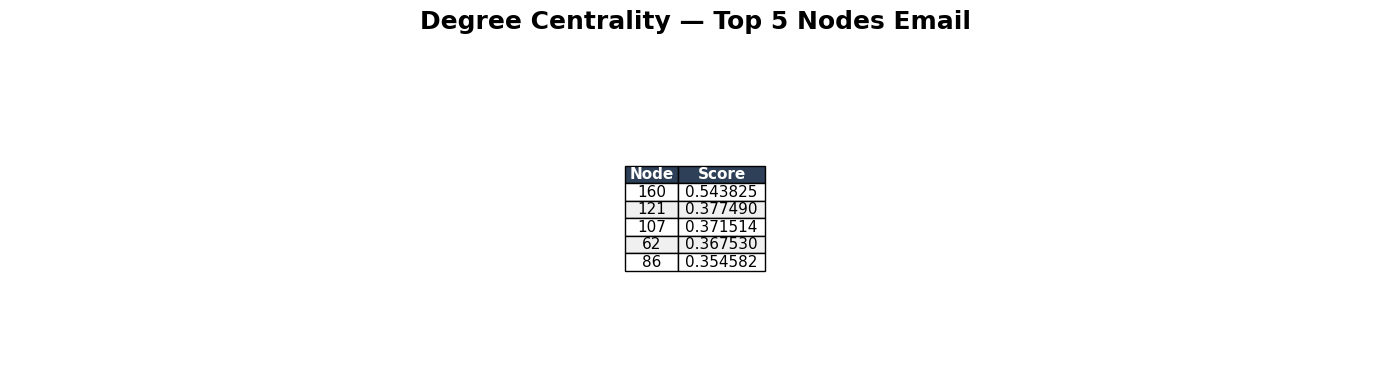


Summary table saved successfully as 'results/email/Centrality Metrics/Top5centrality_degree_EmailNetwork.png'


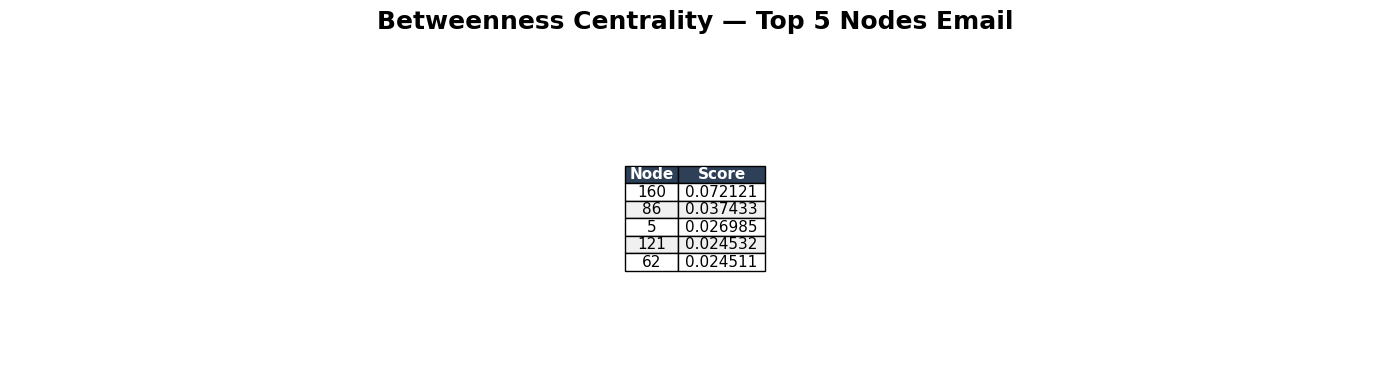


Summary table saved successfully as 'results/email/Centrality Metrics/Top5centrality_betweenness_EmailNetwork.png'


In [ ]:
# Degree centrality table:
df_degree_top5 = top5_nodes(centralities['Degree'])
save_table_as_image(df_degree_top5, 'Degree Centrality — Top 5 Nodes Email',
        f'{results_dir_email}Centrality Metrics/Top5centrality_degree_EmailNetwork.png', fontsize = 11)

# Betweeness centrality table:
df_betweenness_top5 = top5_nodes(centralities['Betweenness'])
save_table_as_image(df_betweenness_top5, 'Betweenness Centrality — Top 5 Nodes Email', 
        f'{results_dir_email}Centrality Metrics/Top5centrality_betweenness_EmailNetwork.png', fontsize = 11)

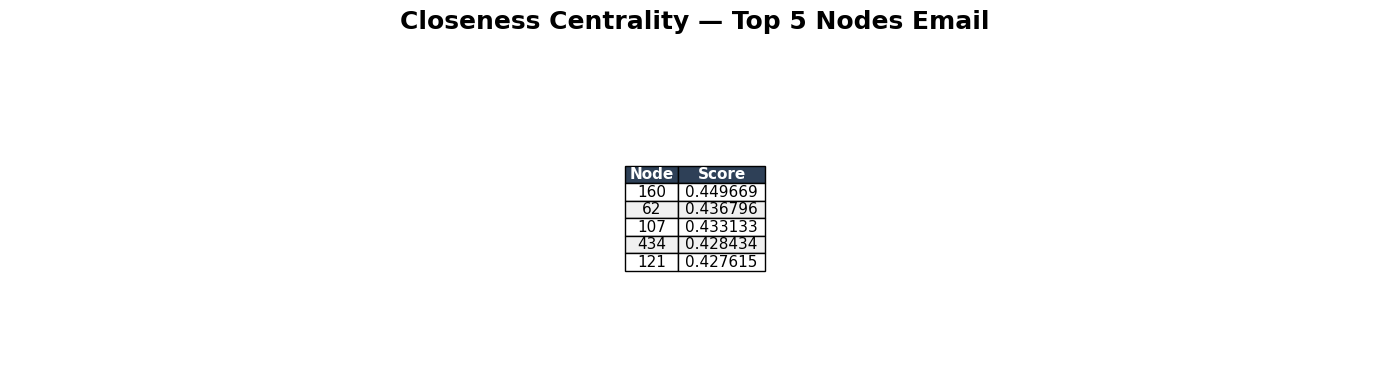


Summary table saved successfully as 'results/email/Centrality Metrics/Top5centrality_closeness_EmailNetwork.png'


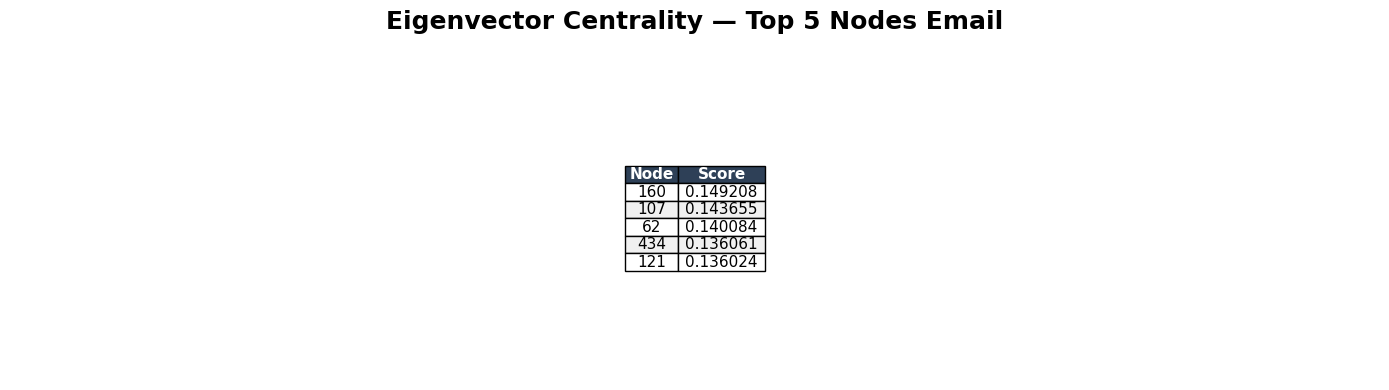


Summary table saved successfully as 'results/email/Centrality Metrics/Top5centrality_eigenvector_EmailNetwork.png'


In [ ]:
# Closeness centrality table:
closeness_top5 = top5_nodes(centralities['Closeness'])
save_table_as_image(closeness_top5, 'Closeness Centrality — Top 5 Nodes Email', 
    f'{results_dir_email}Centrality Metrics/Top5centrality_closeness_EmailNetwork.png', fontsize = 11)

# Eigenvector centrality table:
eigenvector_top5 = top5_nodes(centralities['Eigenvector'])
save_table_as_image(eigenvector_top5, 'Eigenvector Centrality — Top 5 Nodes Email', 
    f'{results_dir_email}Centrality Metrics/Top5centrality_eigenvector_EmailNetwork.png', fontsize = 11)

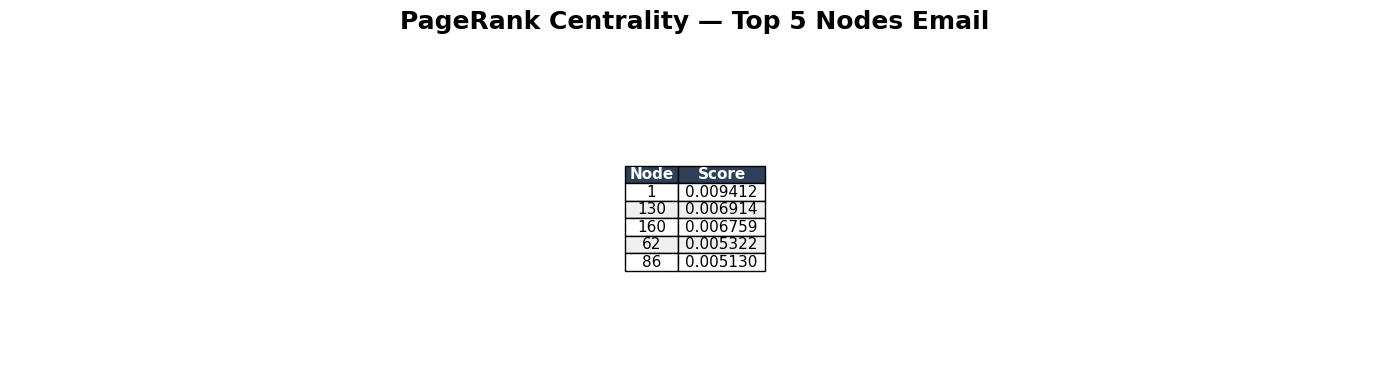


Summary table saved successfully as 'results/email/Centrality Metrics/Top5centrality_pagerank_EmailNetwork.png'


In [ ]:
# PageRank centrality table:
pagerank_top5 = top5_nodes(centralities['PageRank'])
save_table_as_image(pagerank_top5, 'PageRank Centrality — Top 5 Nodes Email', 
        f'{results_dir_email}Centrality Metrics/Top5centrality_pagerank_EmailNetwork.png', fontsize = 11)

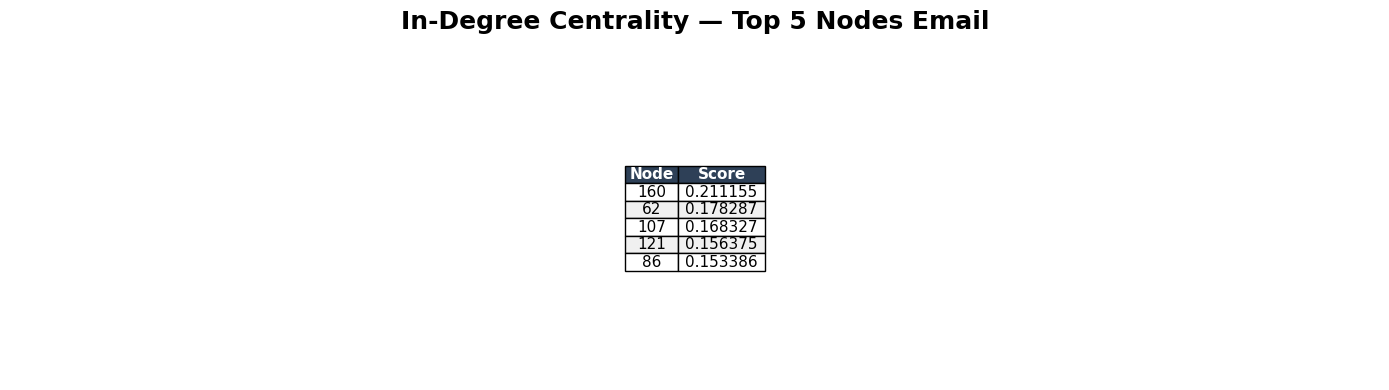


Summary table saved successfully as 'results/email/Centrality Metrics/Top5centrality_in_degree_EmailNetwork.png'


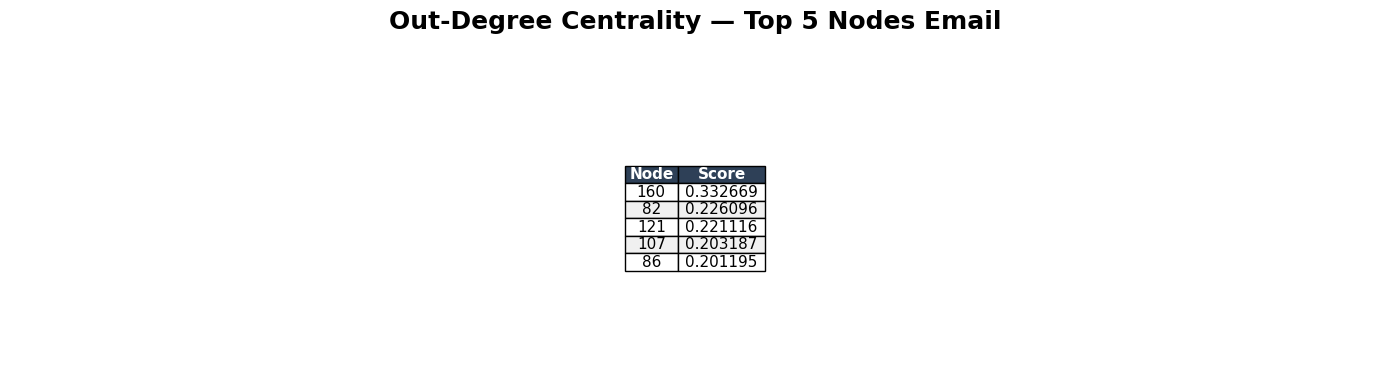


Summary table saved successfully as 'results/email/Centrality Metrics/Top5centrality_out_degree_EmailNetwork.png'


In [ ]:
# In Degree centrality table:
in_degree_top5 = top5_nodes(centralities['In-Degree'])
save_table_as_image(in_degree_top5, 'In-Degree Centrality — Top 5 Nodes Email', 
    f'{results_dir_email}Centrality Metrics/Top5centrality_in_degree_EmailNetwork.png', fontsize = 11)

# Out Degree centrality table:
out_degree_top5 = top5_nodes(centralities['Out-Degree'])
save_table_as_image(out_degree_top5, 'Out-Degree Centrality — Top 5 Nodes Email', 
    f'{results_dir_email}Centrality Metrics/Top5centrality_out_degree_EmailNetwork.png', fontsize = 11)

# Community Detection

In this section, we aim to compute/detect the communities on each dataset using at three different detection community algorithms. These are the **Clique Percolation Method (CPM)**, which is based on *k-cliques*, the **Louvain** algorithm, which is based on *modularity*, and the **Walktrap** approach, which is based on the random walks.

Also, we aim to use different metrics to evaluate the quality of the communities.

First, we have defined three functions: `cpm_communities()`, `louvain_communities()`, and `walktrap_communities()` which correspond to the CPM, Louvain, and Walktrap community detection algorithms respectively. These are defined below.

In [60]:
# CPM community detection algorithm:
def cpm_communities(G, clique_limit, k=3):
    cliques = list(nx.find_cliques(G))
    # we add a clique limit for computational reasons.
    k_cliques = [c for c in cliques if len(c) >= k][:clique_limit]  # Limit cliques
    
    if len(k_cliques) == 0:
        return []
    
    # Build clique graph (cliques connected if overlap k-1 nodes)
    clique_graph = nx.Graph()
    clique_graph.add_nodes_from(range(len(k_cliques)))
    
    for i, j in combinations(range(len(k_cliques)), 2):
        if len(set(k_cliques[i]) & set(k_cliques[j])) >= k - 1:
            clique_graph.add_edge(i, j)
    
    # Communities = connected components in clique graph
    communities = []
    for component in nx.connected_components(clique_graph):
        community_nodes = set()
        for clique_idx in component:
            community_nodes.update(k_cliques[clique_idx])
        if len(community_nodes) > 1:
            communities.append(community_nodes)
    
    return communities


# Louvain community detection algorithm:
def louvain_communities(G):
    partition_list = nx_louvain(G, seed=42)
    
    # Convert from list of sets to the same format as before
    communities = []
    for comm_nodes in partition_list:
        if len(comm_nodes) > 1:
            communities.append(set(comm_nodes))
    return communities


# Walktrap community detection algorithm:

def walktrap_communities(G, steps=4):
    nodes_list = list(G.nodes())
    n = len(nodes_list)
    
    adj = nx.to_numpy_array(G, nodelist=nodes_list)
    degrees = adj.sum(axis=1)
    degrees[degrees == 0] = 1
    P = adj / degrees[:, np.newaxis]
    
    # Compute P^steps (proper matrix power, not accumulation)
    P_t = np.linalg.matrix_power(P, steps)
    
    # True Walktrap distance: || P^t[u]/sqrt(d[u]) - P^t[v]/sqrt(d[v]) ||
    D = np.sqrt(degrees)
    P_norm = P_t / D[:, np.newaxis]
    
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            diff = P_norm[i] - P_norm[j]
            dist_matrix[i, j] = np.sqrt(np.dot(diff, diff))
            dist_matrix[j, i] = dist_matrix[i, j]
    
    Z = linkage(dist_matrix, method='average')
    
    # Pick k that maximises modularity
    best_k, best_mod = 2, -1
    for k in range(2, min(20, n)):
        labels = fcluster(Z, t=k, criterion='maxclust')
        partition = {}
        for node, label in zip(nodes_list, labels):
            partition.setdefault(label, set()).add(node)
        mod = nx.community.modularity(G, list(partition.values()))
        if mod > best_mod:
            best_mod = mod
            best_k = k
    
    labels = fcluster(Z, t=best_k, criterion='maxclust')
    partition = {}
    for node, label in zip(nodes_list, labels):
        partition.setdefault(label, set()).add(node)
    
    return [c for c in partition.values() if len(c) > 1]


Now, we define the function `compute_community_metrics()`, which computes 4 community quality metrics:
1. **Number of detected communities** the algorithm found.

2. **Modularity score** for the entiry community structure. Higher value means better overall community structure.

3. **Intra Density**: measures global edge containment in communities. Value within 0 (no edges inside communities $\to$ completely disconnected) and 1 (all edges inside communities $\to$ perfect partition).

4. **Average Size of communities**: avg. number of nodes per community.

This 4 metrics evaluate the quality of the communities found by each of the previous algorithms.

In [61]:
def compute_community_metrics(G, communities):
    if not communities:
        return {
            'Number of Communities': 0,
            'Modularity Score': 0.0,
            'Intra Density': 0.0,
            'Avg. Size': 0.0
        }
    
    # Create complete partition by assigning uncovered nodes to singleton communities
    covered_nodes = set()
    for comm in communities:
        covered_nodes.update(comm)
    
    uncovered_nodes = set(G.nodes()) - covered_nodes
    complete_partition = list(communities) + [ {node} for node in uncovered_nodes ]

    # 1. Number of communities
    n_communities = len(complete_partition)
    # 2. Modularity
    modularity = nx.community.modularity(G, complete_partition)
    
    # 3. Intra-community density
    total_intra_edges = sum(len(G.subgraph(c).edges()) for c in communities if len(c) > 1)
    total_edges = G.number_of_edges()
    intra_density = total_intra_edges / total_edges if total_edges > 0 else 0.0
    # 4. Average size
    avg_size = np.mean([len(c) for c in communities]) if communities else 0.0
    
    return {
        f'Number of Communities': n_communities,
        f'Modularity Score': modularity,
        f'Intra Density': intra_density,
        f'Avg. Size': avg_size
    }

Now that we have chosen and implemented the community detection algorithms and the metrics to evaluate the quality of the communities found, we apply these to our datasets.

We will start first with the Facebook dataset and then move on to the Email dataset.

### Facebook dataset

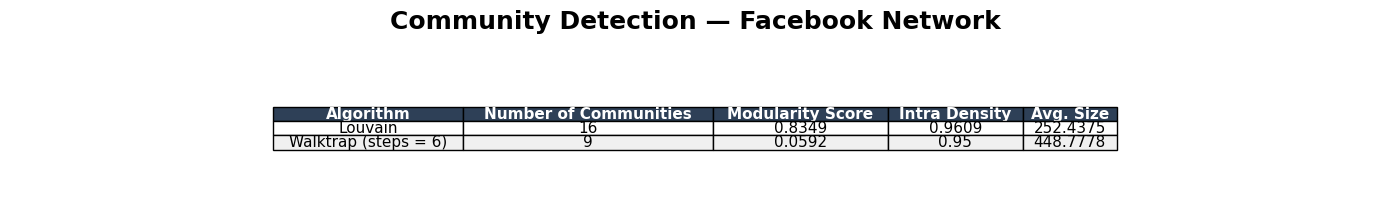


Summary table saved successfully as 'results/email/Communities/facebook_community_detection_Louvain_Walktrap6.png'


In [ ]:
# # FACEBOOK NETWORK COMMUNITIES ANALYSIS
steps_walktrap = 6
# Run both algorithms on network
louvain_comms_facebook = louvain_communities(facebook_network)
walktrap_comms_facebook = walktrap_communities(facebook_network, steps=steps_walktrap)

# Compute metrics for both algorithms
louvain_metrics = compute_community_metrics(facebook_network, louvain_comms_facebook)
walktrap_metrics = compute_community_metrics(facebook_network, walktrap_comms_facebook)

# Create results with 2 rows (one per algorithm)
facebook_results = [
    {
        'Algorithm': 'Louvain',
        **louvain_metrics
    },
    {
        'Algorithm': f'Walktrap (steps = {steps_walktrap})',
        **walktrap_metrics
    }
]

# Communities summary table
df_facebook = pd.DataFrame(facebook_results)

save_table_as_image(df_facebook.round(4), title='Community Detection — Facebook Network',
    filename = f'{results_dir_facebook}Communities/facebook_community_detection_Louvain_Walktrap{steps_walktrap}.png',
    fontsize=11)

### Email dataset

**`NOTE:`** The community detection algorithms: Louvain, CPM and Walktrap are designed for undirected graphs. Therefore, to be able to use them for our email dataset (directed graph), we first convert the directed graph to an undirected graph using `G.to_undirected()` before applying these community detection algorithms.

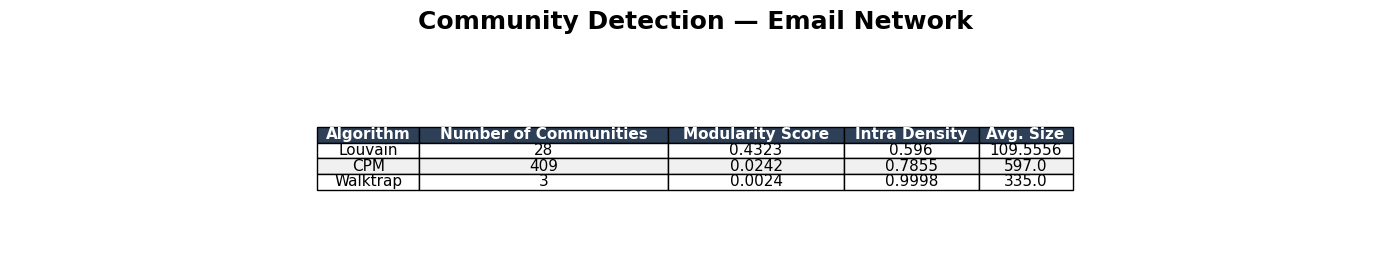


Summary table saved successfully as 'results/email/Communities/email_community_detection_Louvain_CPM_Walktrap6.png'


In [ ]:
# EMAIL NETWORK COMMUNITIES ANALYSIS
email_network_und = email_network.to_undirected()
# Run the three algorithms on network
louvain_comms_email = louvain_communities(email_network_und)
cpm_comms_email = cpm_communities(email_network_und, 10000, k=3) # 3-cliques
walktrap_comms_email = walktrap_communities(email_network_und, steps=steps_walktrap)

# Compute metrics for both algorithms
louvain_metrics = compute_community_metrics(email_network_und, louvain_comms_email)
cpm_metrics = compute_community_metrics(email_network_und, cpm_comms_email)
walktrap_metrics = compute_community_metrics(email_network_und, walktrap_comms_email)

# Create results with 3 rows (one per algorithm)
email_results = [
    {
        'Algorithm': 'Louvain',
        **louvain_metrics
    },
    {
        'Algorithm': 'CPM',
        **cpm_metrics
    },
    {
        'Algorithm': 'Walktrap',
        **walktrap_metrics
    }
]

# Communities summary table
df_email = pd.DataFrame(email_results)

save_table_as_image(df_email.round(4), title='Community Detection — Email Network',
    filename=f'{results_dir_email}Communities/email_community_detection_Louvain_CPM_Walktrap{steps_walktrap}.png',
    fontsize=11)

## Summary Comparison for Part I: Facebook vs Email Network

                                     NETWORK COMPARISON: FACEBOOK vs EMAIL-EU-CORE


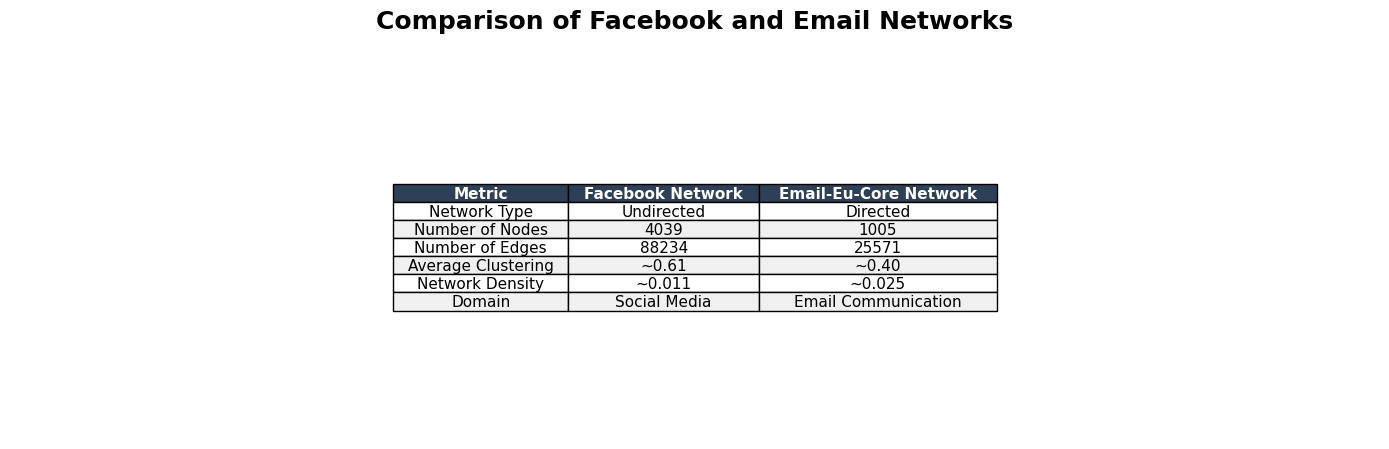


Summary table saved successfully as 'results/facebook_vs_email_network_comparison.png'

                                 KEY INSIGHTS

1. Facebook networks show higher clustering (people's friends tend to be
   friends with each other - social triangles).

2. Email network is smaller and sparser, with directed edges showing
   asymmetric communication patterns.

3. Both networks exhibit small-world properties with short path lengths
   despite large size.

4. Email network shows lower reciprocity than typical social networks,
   indicating hierarchical communication patterns (e.g., supervisor to staff).


In [ ]:
# Create a comparison table
print("="*120)
print("                                     NETWORK COMPARISON: FACEBOOK vs EMAIL-EU-CORE")
print("="*120)

comparison_data = {
    'Metric': [
        'Network Type',
        'Number of Nodes',
        'Number of Edges',
        'Average Clustering',
        'Network Density',
        'Domain'
    ],
    'Facebook Network': [
        'Undirected',
        '4039',
        '88234',
        '~0.61',
        '~0.011',
        'Social Media'
    ],
    'Email-Eu-Core Network': [
        'Directed',
        '1005',
        '25571',
        '~0.40',
        '~0.025',
        'Email Communication'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
save_table_as_image(comparison_df, title='Comparison of Facebook and Email Networks',
    filename = 'results/facebook_vs_email_network_comparison.png', fontsize=11)

print("\n" + "="*80)
print("                                 KEY INSIGHTS")
print("="*80)
print("\n1. Facebook networks show higher clustering (people's friends tend to be")
print("   friends with each other - social triangles).")
print("\n2. Email network is smaller and sparser, with directed edges showing")
print("   asymmetric communication patterns.")
print("\n3. Both networks exhibit small-world properties with short path lengths")
print("   despite large size.")
print("\n4. Email network shows lower reciprocity than typical social networks,")
print("   indicating hierarchical communication patterns (e.g., supervisor to staff).")


# PART II: Graph Embeddings

## Node2Vec Feasibility Analysis

**Node2Vec** is a graph embedding algorithm that learns continuous vector representations of nodes by performing biased random walks on the graph, then applying a Skip-Gram model (similar to Word2Vec) on the resulting sequences. It captures both **homophily** (nearby nodes get similar embeddings) and **structural equivalence** (nodes with similar roles get similar embeddings) through two parameters:
- **p** (return parameter): controls the likelihood of revisiting the previous node.
- **q** (in-out parameter): controls exploration vs. exploitation (BFS-like vs. DFS-like walks).

In this section, we evaluate whether Node2Vec is a suitable approach for our two datasets by checking key graph properties and, if the library is available, by running Node2Vec and evaluating the quality of the resulting embeddings.

### 1. Graph Property Assessment

Node2Vec is well-suited for graphs that exhibit:
1. **Moderate to large size** (hundreds to millions of nodes).
2. **Sparsity** — dense graphs offer less structural variation for random walks to capture.
3. **Clear community structure** — high modularity indicates meaningful clusters that Node2Vec can learn.
4. **High clustering coefficient** — signals local homophily, which biased random walks exploit.
5. **Connectivity** — random walks require the graph to be connected (or at least have a large connected component).
6. **Heterogeneous degree distribution** — varied node degrees allow the p/q parameters to meaningfully steer walks.

In [ ]:
def assess_node2vec_suitability(G, name, is_directed=False):
    G_und = G.to_undirected() if is_directed else G

    n_nodes = G_und.number_of_nodes()
    n_edges = G_und.number_of_edges()
    density = nx.density(G_und)
    avg_clustering = nx.average_clustering(G_und)

    largest_cc = max(nx.connected_components(G_und), key=len)
    lcc_fraction = len(largest_cc) / n_nodes

    communities = nx_louvain(G_und, seed=42)
    modularity = nx.community.modularity(G_und, communities)

    degrees = np.array([d for _, d in G_und.degree()])
    degree_cv = np.std(degrees) / np.mean(degrees) if np.mean(degrees) > 0 else 0

    criteria = {}

    # 1. Size
    if n_nodes >= 100:
        criteria['Graph Size'] = (f"{n_nodes} nodes, {n_edges} edges", "SUITABLE",
            "Node2Vec handles medium-to-large graphs efficiently.")
    else:
        criteria['Graph Size'] = (f"{n_nodes} nodes, {n_edges} edges", "MARGINAL",
            "Very small graph; simpler methods may suffice.")

    # 2. Sparsity
    if density < 0.1:
        criteria['Sparsity'] = (f"Density = {density:.4f}", "SUITABLE",
            "Sparse graph — random walks can explore diverse structural patterns.")
    elif density < 0.3:
        criteria['Sparsity'] = (f"Density = {density:.4f}", "MODERATE",
            "Moderately dense — Node2Vec still works but with less structural variation.")
    else:
        criteria['Sparsity'] = (f"Density = {density:.4f}", "LESS SUITABLE",
            "Dense graph — limited structural diversity for random walks.")

    # 3. Community structure
    if modularity >= 0.3:
        criteria['Community Structure'] = (f"Modularity = {modularity:.4f}", "SUITABLE",
            "Strong community structure that Node2Vec can capture effectively.")
    elif modularity >= 0.1:
        criteria['Community Structure'] = (f"Modularity = {modularity:.4f}", "MODERATE",
            "Moderate community structure — Node2Vec may still find meaningful patterns.")
    else:
        criteria['Community Structure'] = (f"Modularity = {modularity:.4f}", "LESS SUITABLE",
            "Weak community structure — Node2Vec may not provide significant benefit.")

    # 4. Clustering coefficient
    if avg_clustering >= 0.3:
        criteria['Clustering Coefficient'] = (f"Avg CC = {avg_clustering:.4f}", "SUITABLE",
            "High clustering indicates local homophily — ideal for biased random walks.")
    elif avg_clustering >= 0.1:
        criteria['Clustering Coefficient'] = (f"Avg CC = {avg_clustering:.4f}", "MODERATE",
            "Moderate clustering — some homophily for Node2Vec to exploit.")
    else:
        criteria['Clustering Coefficient'] = (f"Avg CC = {avg_clustering:.4f}", "LESS SUITABLE",
            "Low clustering — limited local structure for random walks.")

    # 5. Connectivity
    if lcc_fraction >= 0.9:
        criteria['Connectivity'] = (f"LCC covers {lcc_fraction*100:.1f}% of nodes", "SUITABLE",
            "Well-connected graph — random walks can reach most nodes.")
    elif lcc_fraction >= 0.5:
        criteria['Connectivity'] = (f"LCC covers {lcc_fraction*100:.1f}% of nodes", "MODERATE",
            "Partially connected — embeddings may not be meaningful for isolated components.")
    else:
        criteria['Connectivity'] = (f"LCC covers {lcc_fraction*100:.1f}% of nodes", "LESS SUITABLE",
            "Fragmented graph — Node2Vec random walks will be confined to small components.")

    # 6. Degree distribution heterogeneity
    if degree_cv >= 1.0:
        criteria['Degree Heterogeneity'] = (f"CV = {degree_cv:.4f}", "SUITABLE",
            "High variation in degrees — p/q parameters can meaningfully steer walks.")
    elif degree_cv >= 0.5:
        criteria['Degree Heterogeneity'] = (f"CV = {degree_cv:.4f}", "MODERATE",
            "Moderate degree variation — Node2Vec parameters have some effect.")
    else:
        criteria['Degree Heterogeneity'] = (f"CV = {degree_cv:.4f}", "LESS SUITABLE",
            "Homogeneous degrees — biased walks offer little advantage over standard walks.")




    # Print results
    print("\n" + "=" * 90)
    print(f"          NODE2VEC SUITABILITY ASSESSMENT — {name}")
    print("=" * 90)

    suitable_count = 0
    total = len(criteria)

    for criterion, (value, verdict, explanation) in criteria.items():
        symbol = "+" if verdict == "SUITABLE" else ("~" if verdict == "MODERATE" else "-")
        print(f"\n  [{symbol}] {criterion}: {value}")
        print(f"      Verdict: {verdict}")
        print(f"      {explanation}")
        if verdict == "SUITABLE":
            suitable_count += 1
        elif verdict == "MODERATE":
            suitable_count += 0.5

    # Overall verdict
    score = suitable_count / total
    print("\n" + "-" * 90)
    print(f"  OVERALL SCORE: {suitable_count}/{total} criteria met ({score*100:.0f}%)")

    if score >= 0.7:
        print(f"  VERDICT: Node2Vec is a GOOD FIT for the {name}.")
    elif score >= 0.4:
        print(f"  VERDICT: Node2Vec is a REASONABLE choice for the {name}, but may have limitations.")
    else:
        print(f"  VERDICT: Node2Vec may NOT be ideal for the {name}. Consider alternatives.")
    print("=" * 90)

    return criteria, score


# Assess Facebook network
fb_criteria, fb_score = assess_node2vec_suitability(facebook_network, "Facebook Network", is_directed=False)

# Assess Email network
email_criteria, email_score = assess_node2vec_suitability(email_network, "Email-Eu-Core Network", is_directed=True)



          NODE2VEC SUITABILITY ASSESSMENT — Facebook Network

  [+] Graph Size: 4039 nodes, 88234 edges
      Verdict: SUITABLE
      Node2Vec handles medium-to-large graphs efficiently.

  [+] Sparsity: Density = 0.0108
      Verdict: SUITABLE
      Sparse graph — random walks can explore diverse structural patterns.

  [+] Community Structure: Modularity = 0.8349
      Verdict: SUITABLE
      Strong community structure that Node2Vec can capture effectively.

  [+] Clustering Coefficient: Avg CC = 0.6055
      Verdict: SUITABLE
      High clustering indicates local homophily — ideal for biased random walks.

  [+] Connectivity: LCC covers 100.0% of nodes
      Verdict: SUITABLE
      Well-connected graph — random walks can reach most nodes.

  [+] Degree Heterogeneity: CV = 1.1997
      Verdict: SUITABLE
      High variation in degrees — p/q parameters can meaningfully steer walks.

------------------------------------------------------------------------------------------
  OVERALL S

### 2. Degree Distribution Analysis

A heterogeneous (heavy-tailed) degree distribution is favorable for Node2Vec because the biased random walk parameters (p, q) have more meaningful effects when nodes have varied connectivity. Below we plot the degree distributions for both networks on a log-log scale to check for power-law-like behavior.

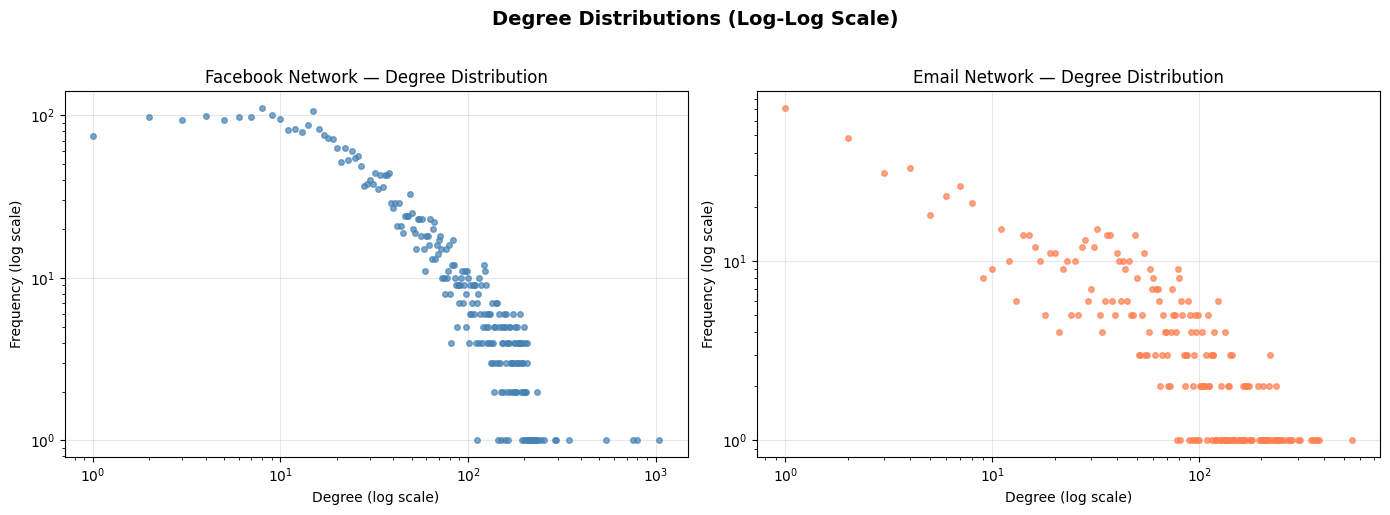


Both networks show heavy-tailed degree distributions,
indicating heterogeneous connectivity — favorable for Node2Vec.


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Facebook degree distribution
fb_degrees = [d for _, d in facebook_network.degree()]
fb_degree_counts = Counter(fb_degrees)
fb_x = sorted(fb_degree_counts.keys())
fb_y = [fb_degree_counts[k] for k in fb_x]

axes[0].loglog(fb_x, fb_y, 'o', color='steelblue', markersize=4, alpha=0.7)
axes[0].set_xlabel('Degree (log scale)')
axes[0].set_ylabel('Frequency (log scale)')
axes[0].set_title('Facebook Network — Degree Distribution')
axes[0].grid(True, alpha=0.3)

# Email degree distribution (using undirected version)
email_degrees = [d for _, d in email_network.degree()]
email_degree_counts = Counter(email_degrees)
email_x = sorted(email_degree_counts.keys())
email_y = [email_degree_counts[k] for k in email_x]

axes[1].loglog(email_x, email_y, 'o', color='coral', markersize=4, alpha=0.7)
axes[1].set_xlabel('Degree (log scale)')
axes[1].set_ylabel('Frequency (log scale)')
axes[1].set_title('Email Network — Degree Distribution')
axes[1].grid(True, alpha=0.3)

plt.suptitle('Degree Distributions (Log-Log Scale)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nBoth networks show heavy-tailed degree distributions,")
print("indicating heterogeneous connectivity — favorable for Node2Vec.")

### 3. Summary: Node2Vec Suitability Comparison

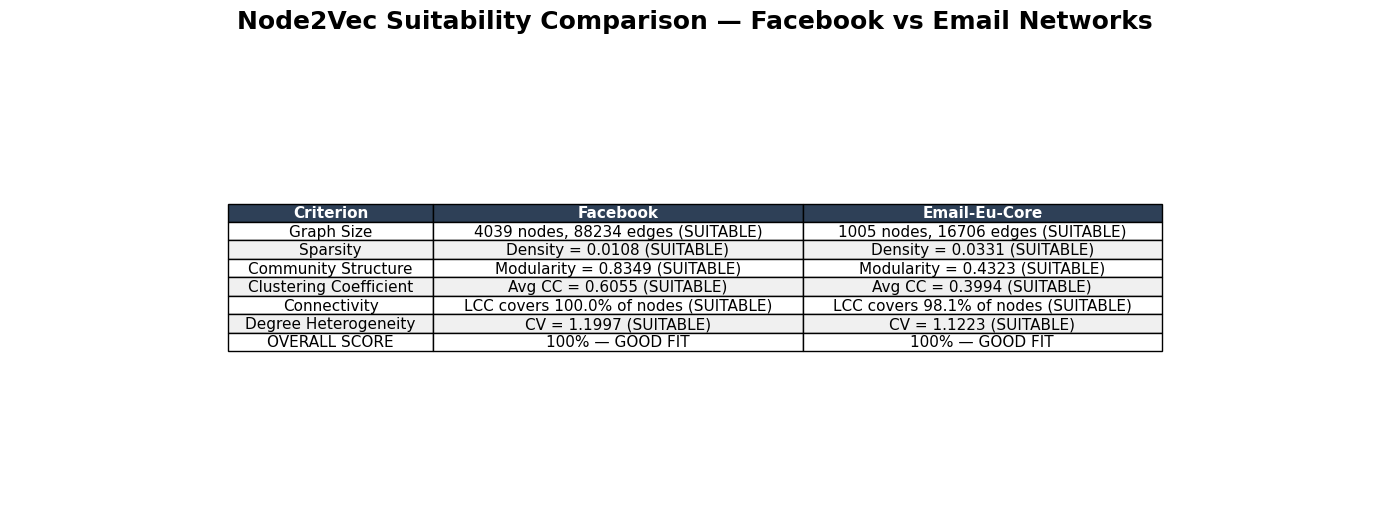


Summary table saved successfully as 'results/node2vec_suitability_comparison.png'

                                          CONCLUSIONS

  - FACEBOOK NETWORK: Node2Vec is well-suited for this dataset. The network is sparse,
    well-connected, and exhibits strong community structure (high modularity ~0.83) and
    high clustering (~0.61). The biased random walks can effectively capture the tight-knit
    social circles (ego networks) and the homophily inherent in friendship networks.

  - EMAIL NETWORK: Node2Vec is also a reasonable-to-good fit. The network has moderate
    community structure (modularity ~0.43) and meaningful clustering (~0.40). The directed
    nature introduces asymmetry (not all emails are reciprocated), which standard Node2Vec
    handles by converting to undirected — some directional information is lost. For tasks
    that rely on directionality (e.g., predicting who emails whom), extensions like
    Directed Node2Vec or SDNE may be more appropriate.

  - RECOM

In [ ]:
# Build comparison table
comparison_rows = []
for criterion in fb_criteria:
    fb_val, fb_verdict, _ = fb_criteria[criterion]
    em_val, em_verdict, _ = email_criteria[criterion]
    comparison_rows.append({
        'Criterion': criterion,
        'Facebook': f"{fb_val} ({fb_verdict})",
        'Email-Eu-Core': f"{em_val} ({em_verdict})"
    })

comparison_rows.append({
    'Criterion': 'OVERALL SCORE',
    'Facebook': f"{fb_score*100:.0f}% — {'GOOD FIT' if fb_score >= 0.7 else 'REASONABLE' if fb_score >= 0.4 else 'NOT IDEAL'}",
    'Email-Eu-Core': f"{email_score*100:.0f}% — {'GOOD FIT' if email_score >= 0.7 else 'REASONABLE' if email_score >= 0.4 else 'NOT IDEAL'}"
})

df_n2v_comparison = pd.DataFrame(comparison_rows)
save_table_as_image(df_n2v_comparison, title = "Node2Vec Suitability Comparison — Facebook vs Email Networks",        
    filename = "results/node2vec_suitability_comparison.png", fontsize=11)

print("\n" + "=" * 100)
print("                                          CONCLUSIONS")
print("=" * 100)
print("""
  - FACEBOOK NETWORK: Node2Vec is well-suited for this dataset. The network is sparse,
    well-connected, and exhibits strong community structure (high modularity ~0.83) and
    high clustering (~0.61). The biased random walks can effectively capture the tight-knit
    social circles (ego networks) and the homophily inherent in friendship networks.

  - EMAIL NETWORK: Node2Vec is also a reasonable-to-good fit. The network has moderate
    community structure (modularity ~0.43) and meaningful clustering (~0.40). The directed
    nature introduces asymmetry (not all emails are reciprocated), which standard Node2Vec
    handles by converting to undirected — some directional information is lost. For tasks
    that rely on directionality (e.g., predicting who emails whom), extensions like
    Directed Node2Vec or SDNE may be more appropriate.

  - RECOMMENDATION: Node2Vec is a strong choice for both datasets, particularly for
    tasks like node classification, community-aware embedding, and link prediction.
    The Facebook network benefits more due to its stronger community structure.
""")

## Facebook Network - Node2Vec Analysis

Both networks score 100% on the Node2Vec suitability criteria, so technically either could be used. However, we focus the embedding analysis exclusively on the **Facebook network** for two reasons:

- **Stronger community structure** — Facebook's modularity (~0.83) is nearly double that of the Email network (~0.43). Node2Vec's biased random walks are most informative when communities are well-defined, since the `p`/`q` parameters steer walks *into* or *around* community boundaries. With weaker community structure, the difference between configurations is harder to interpret.
- **Directed graph limitation** — the Email network is a **directed** graph (edges represent who emailed whom). Standard Node2Vec is designed for undirected graphs and handles directed networks by converting them to undirected first, which discards asymmetric information (e.g., A emails B does not imply B emails A). For tasks that depend on directionality, extensions such as *Directed Node2Vec* or *SDNE* would be more appropriate. Since we would lose that directional signal anyway, the Facebook network is the better candidate.

The analysis of the Facebook network is structured in four steps:

1. **Configuration comparison** — train two Node2Vec models with different `(p, q)` parameters and compare their t-SNE projections, both coloured by Louvain community labels from Part I.
2. **Deeper structural comparison** — for each configuration, show the *same* t-SNE projection coloured by (a) K-Means clusters on the embeddings and (b) Louvain labels, so any visual mismatch is purely a labeling difference, not a layout artifact.
3. **Quantitative metrics** — NMI and intra/inter cosine similarity ratio to numerically measure how much each configuration's geometry agrees with the Louvain partition.
4. **Ground-truth evaluation** — compare all methods against the real human-defined social circles from the `.circles` files to see which comes closest to actual perceived friend groups.

### Node2Vec Implementation

Now that we have confirmed that the Facebook network is a strong candidate for Node2Vec, we implement the algorithm in two stages:

1. **Biased random walk generation** — implemented from scratch using the `node2vec_walk()` function. 
Each walk is controlled by two parameters:
   - `p` (return parameter): probability of revisiting the previous node — high `p` discourages backtracking.
   - `q` (in-out parameter): controls exploration vs. exploitation — low `q` favours DFS-like walks (go far), high `q` favours BFS-like walks (stay local).

2. **Skip-gram training via gensim Word2Vec** — the random walk sequences are treated as "sentences" and nodes as "words". 
Gensim's `Word2Vec` with `sg = 1` (Skip-gram) and negative sampling (`negative = 5`) learns embeddings such that nodes co-occurring in the same walk window end up with similar vectors. 
The result is a 32-dimensional embedding vector per node.

The t-SNE visualisations below project these 32-dimensional vectors to 2D for visualization purposes.

In [ ]:
# biased random walk function for Node2Vec
def node2vec_walk(G, start, walk_length, p, q):
    walk = [start]
    while len(walk) < walk_length:
        cur = walk[-1]
        neighbors = list(G.neighbors(cur))
        if not neighbors:
            break
        if len(walk) == 1:
            walk.append(random.choice(neighbors))
        else:
            prev = walk[-2]
            probs = []
            for nb in neighbors:
                if nb == prev: # return to previous node
                    probs.append(1.0 / p)
                elif G.has_edge(nb, prev):
                    probs.append(1.0)
                else:
                    probs.append(1.0 / q)
            probs = np.array(probs, dtype=float)
            probs /= probs.sum()
            walk.append(np.random.choice(neighbors, p=probs))
    return walk


# function to generate multiple walks from each node
def generate_walks(G, num_walks, walk_length, p, q, seed=42):
    random.seed(seed)
    np.random.seed(seed)
    walks = []
    nodes = list(G.nodes())
    for _ in range(num_walks):
        random.shuffle(nodes)
        for node in nodes:
            walks.append(node2vec_walk(G, node, walk_length, p, q))
    return walks


# function to run Node2Vec and train Word2Vec embeddings
def run_node2vec(G, name, p=1.0, q=1.0, num_walks=10, walk_length=80, embedding_dim=64, window_size=5, num_epochs=5,
                neg_samples=5, seed=42):

    walks = generate_walks(G, num_walks, walk_length, p, q, seed=seed)
    walks_str = [[str(n) for n in walk] for walk in walks]

    model = Word2Vec(sentences=walks_str, vector_size=embedding_dim, window=window_size, min_count=0, sg=1,
        negative=neg_samples, epochs=num_epochs, workers=4, seed=seed)

    node_list = sorted(G.nodes())
    embeddings = np.array([model.wv[str(n)] for n in node_list])
    return embeddings, node_list

### Link Prediction step 1: Train/Test Edge Split

Before training anything, we set aside **20% of the real friendships** as a held-out test set. The remaining 80% are used for training, and the hidden edges are only used at the end to evaluate our predictions.

We do this before training Node2Vec because if we train Node2Vec on the full graph first and split the edges afterwards, the embeddings will have already seen the test edges during the random walks.

To avoid this, we work with two separate graphs:
- `facebook_network`: the full graph, used only for the embedding analysis above.
- `G_train`: the same graph but with the test edges removed, used to train the link prediction embeddings (`lp_emb_*`).

This way, the random walks during link prediction training never cross a test edge.


In [ ]:
# STEP 1 for link prediction: we split edges before training any Node2Vec model
# we do that here so that G_train (used for link-prediction embeddings) never contains the held-out test edges

random.seed(42)
np.random.seed(42)

all_edges = list(facebook_network.edges())
print(f"Total edges in graph: {len(all_edges)}")

train_edges, test_edges = train_test_split(all_edges, test_size=0.2, random_state=42)
print(f"Train edges: {len(train_edges)} | Test edges: {len(test_edges)}")

# we build graph with test edges removed: used only for link-prediction embeddings
G_train = facebook_network.copy()
G_train.remove_edges_from(test_edges)
print(f"G_train: {G_train.number_of_nodes()} nodes, {G_train.number_of_edges()} edges"
      f"(removed {len(test_edges)} test edges for training link-prediction embeddings)")

Total edges in graph: 88234
Train edges: 70587 | Test edges: 17647
G_train: 4039 nodes, 70587 edges (removed 17647 test edges for training link-prediction embeddings)


In [ ]:
# Link-prediction embeddings (trained on G_train)
lp_emb_homophily, lp_nodes_homophily = run_node2vec(G_train, name="G_train — Homophily (p=1, q=0.5) - link prediction", p=1.0, q=0.5, num_walks=20, walk_length=80, embedding_dim=32, num_epochs=5, seed=42)

lp_emb_structural, lp_nodes_structural = run_node2vec(G_train, name="G_train — Structural (p=1, q=2) - link prediction", p=1.0, q=2.0, num_walks=20, walk_length=80, embedding_dim=32, num_epochs=5, seed=42)

### Training Node2Vec on the Facebook Network

We train with two different `(p, q)` configurations to illustrate the difference between the two exploration strategies:

| Configuration | p | q | Behaviour |
|---|---|---|---|
| **Homophily** | 1 | 0.5 | DFS-like — explores broadly, captures community membership |
| **Structural** | 1 | 2 | BFS-like — stays local, captures structural roles |

In [ ]:
# Facebook: Homophily configuration (p=1, q=0.5)
fb_emb_homophily, fb_nodes_homophily = run_node2vec(facebook_network, name = "Facebook — Homophily (p=1, q=0.5)", p = 1.0, q = 0.5, num_walks = 20, walk_length = 80,
    embedding_dim = 32, num_epochs = 5, seed = 42)

In [ ]:
# Facebook: Structural equivalence configuration (p=1, q=2)
fb_emb_structural, fb_nodes_structural = run_node2vec(facebook_network, name = "Facebook — Structural (p=1, q=2)", p = 1.0, q = 2.0, num_walks = 20, walk_length = 80,
    embedding_dim = 32, num_epochs = 5, seed = 42)

### Embedding Analysis and Visualization

Once the Node2Vec embeddings are trained, we analyse and compare them in four steps:

1. **Configuration comparison** — project each configuration's embeddings independently to 2D with t-SNE, 
coloured by Louvain community. This gives a first visual impression of what each configuration learned: tight monochromatic clusters suggest the embedding captured community structure, mixed colours suggest it captured something else (e.g. structural roles).

**`Note:`** t-SNE plots are not meant to evaluate correctness,that is what **NMI** is for. What t-SNE shows us is the **overall structure**: how many groups exist, how separated they are, and whether the general distribution of points looks similar between left and right. We can basically check if the overall big picture look similar, not whether individual nodes are correctly assigned.

2. **K-Means vs Louvain comparison** — for each configuration, run K-Means (k = number of Louvain communities) directly on the 32-dimensional embeddings, then show both labelings on the **same t-SNE projection**. 
Since the 2D layout is identical between the two panels, any visual mismatch is purely a labeling difference, not a projection artifact. This makes the comparison honest.

3. **Quantitative metrics** — NMI and intra/inter cosine similarity ratio to numerically measure how much each configuration's embedding geometry agrees with the Louvain partition.

4. **Ground-truth evaluation** — repeat the K-Means vs labels comparison but against the real human-defined social circles from the `.circles` files, and compute NMI for Louvain, homophily, and structural configurations 
side by side.

#### Helper Functions

In [ ]:
def get_louvain_colors(G, node_list):  # returns (community_id_per_node, colormap_array)

    communities = nx_louvain(G, seed=42)

    partition = {} # partition dict {node: community_id}

    for comm_id, comm in enumerate(communities):
        for node in comm:
            partition[node] = comm_id

    community_ids = np.array([partition[n] for n in node_list])
    n_communities = len(set(community_ids))

    cmap = plt.cm.get_cmap('tab20', n_communities)
    colors = np.array([cmap(c % 20) for c in community_ids])
    return community_ids, colors, n_communities, cmap


def tsne_project(embeddings, seed=42, perplexity=40):
    scaler = StandardScaler()
    X = scaler.fit_transform(embeddings)
    tsne = TSNE(n_components=2, perplexity=perplexity,
                max_iter=1000, random_state=seed, init='pca')
    return tsne.fit_transform(X)


def plot_embeddings_side_by_side(emb_left, nodes_left, emb_right, nodes_right, G, title_left, title_right, main_title, perplexity=40, save_path=None, dpi=300):
    
    # Plot two t-SNE projections side by side
    proj_left  = tsne_project(emb_left,  perplexity=perplexity)
    proj_right = tsne_project(emb_right, perplexity=perplexity)

    comm_left,  colors_left,  n_comm_left,  cmap_left  = get_louvain_colors(G, nodes_left)
    comm_right, colors_right, n_comm_right, cmap_right = get_louvain_colors(G, nodes_right)

    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle(main_title, fontsize=15, fontweight='bold', y=1.01)

    for ax, proj, colors, comm_ids, n_comm, cmap, title in [(axes[0], proj_left,  colors_left,  comm_left,  n_comm_left,  cmap_left,  title_left),
        (axes[1], proj_right, colors_right, comm_right, n_comm_right, cmap_right, title_right)]:
        
        ax.scatter(proj[:, 0], proj[:, 1], c=colors, s=12, alpha=0.75, linewidths=0)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel('t-SNE dimension 1')
        ax.set_ylabel('t-SNE dimension 2')
        ax.set_xticks([]); ax.set_yticks([])

        unique_comms = sorted(set(comm_ids))
        patches = [mpatches.Patch(color=cmap(c % 20), label=f'Community {c}') for c in unique_comms]
        ax.legend(handles=patches, loc='upper right', fontsize=5, framealpha=0.8, markerscale=1.2)

    plt.tight_layout()

    # Save figure
    if save_path is not None:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')

    plt.show()



# For a node2vec configuration, it displays 2 panels using same t-SNE projection:
# Left panel:  nodes colored by K-Means clusters on the embedding
# Right panel: nodes colored by LOUVAIN community labels
def plot_node2vec_vs_louvain(emb, nodes, partition, config_name, perplexity = 40, save_path=None, dpi=300):
    scaler = StandardScaler()
    emb_scaled = scaler.fit_transform(emb)

    proj = TSNE(n_components=2, perplexity=perplexity, random_state=42).fit_transform(emb_scaled)

    louvain_labels = np.array([partition[int(n)] for n in nodes])
    n_louvain = len(set(louvain_labels))

    # K-Means on embedding (same k = number of Louvain communities)
    k = n_louvain
    kmeans_labels = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(emb)

    # Colors
    cmap = plt.cm.get_cmap('tab20')
    km_colors  = [cmap(l % 20) for l in kmeans_labels]
    lou_colors = [cmap(l % 20) for l in louvain_labels]

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f"node2vec vs Louvain — {config_name}", fontsize=14, fontweight='bold', y=1.02)

    panels = [(axes[0], km_colors,  kmeans_labels,  f"node2vec K-Means Clusters (k={k})"), (axes[1], lou_colors, louvain_labels, f"Louvain Communities (k={n_louvain})")]

    for ax, colors, labels, title in panels:
        ax.scatter(proj[:, 0], proj[:, 1], c=colors, s=12, alpha=0.75, linewidths=0)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel("t-SNE dim 1")
        ax.set_ylabel("t-SNE dim 2")
        ax.set_xticks([]); ax.set_yticks([])
        unique = sorted(set(labels))
        patches = [mpatches.Patch(color=cmap(l % 20), label=f'Cluster {l}') for l in unique]
        ax.legend(handles=patches, loc='upper right', fontsize=5, framealpha=0.8)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    plt.show()
    
    return {'louvain_labels': louvain_labels, 'kmeans_labels': kmeans_labels, 'emb': emb}





# For a node2vec configuration, it displays 2 panels using same t-SNE projection:
# Left panel:  nodes colored by K-Means clusters on the embedding
# Right panel: nodes colored by FRIENDS CIRCLES community labels
def plot_node2vec_vs_circles(emb, nodes, partition, config_name, perplexity=40, save_path=None, dpi=300):
    
    scaler = StandardScaler()
    emb_scaled = scaler.fit_transform(emb)
    
    proj = TSNE(n_components=2, perplexity=perplexity, random_state=42).fit_transform(emb_scaled)

    # Ground-truth circle labels
    circle_labels = np.array([partition.get(int(n), -1) for n in nodes])
    valid_mask = circle_labels != -1 # only consider nodes with circle labels for K-Means
    n_circles = len(set(circle_labels[valid_mask]))

    k = n_circles
    kmeans_labels = np.full(len(nodes), -1, dtype=int)
    kmeans_labels[valid_mask] = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(emb[valid_mask])

    # Colors
    cmap = plt.cm.get_cmap('tab20')

    km_colors = ['lightgrey' if l == -1 else cmap(l % 20) for l in kmeans_labels]
    lou_colors = []
    for l in circle_labels:
        lou_colors.append('lightgrey' if l == -1 else cmap(l % 20))

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f"node2vec vs Friends Circles — {config_name}", fontsize=14, fontweight='bold', y=1.02)

    panels = [(axes[0], km_colors,  kmeans_labels,  f"node2vec K-Means Clusters (k={k})"), (axes[1], lou_colors, circle_labels,  f"Ego Circles Ground Truth (k={n_circles})")]

    for ax, colors, labels, title in panels:
        ax.scatter(proj[:, 0], proj[:, 1], c=colors, s=12, alpha=0.75, linewidths=0)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel("t-SNE dim 1")
        ax.set_ylabel("t-SNE dim 2")
        ax.set_xticks([]); ax.set_yticks([])
        unique = sorted(set(l for l in labels if l != -1))
        patches = [mpatches.Patch(color=cmap(l % 20), label=f'Circle {l}') for l in unique]
        patches.append(mpatches.Patch(color='lightgrey', label='Unassigned'))
        ax.legend(handles=patches, loc='upper right', fontsize=5, framealpha=0.8)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    plt.show()

    return {'circle_labels': circle_labels, 'kmeans_labels': kmeans_labels, 'emb': emb, 'valid_mask': valid_mask}


# function to compare Louvain communities vs real ego circles
def plot_louvain_vs_circles(partition_louvain, partition_circles, nodes, G, emb, perplexity=40, save_path=None, dpi=300):
    
    scaler = StandardScaler()
    emb_scaled = scaler.fit_transform(emb)
    proj = TSNE(n_components=2, perplexity=perplexity, random_state=42).fit_transform(emb_scaled)
    

    louvain_labels = np.array([partition_louvain[n] for n in nodes])
    circle_labels  = np.array([partition_circles.get(int(n), -1) for n in nodes])

    n_louvain = len(set(louvain_labels))
    n_circles = len(set(l for l in circle_labels if l != -1))

    cmap = plt.cm.get_cmap('tab20')

    lou_colors = [cmap(l % 20) for l in louvain_labels]
    cir_colors = ['lightgrey' if l == -1 else cmap(l % 20) for l in circle_labels]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle("Louvain Communities vs Real Ego Circles",
                 fontsize=14, fontweight='bold', y=1.02)

    panels = [(axes[0], lou_colors, louvain_labels, f"Louvain Communities (k={n_louvain})"), (axes[1], cir_colors, circle_labels, f"Ego Circles Ground Truth (k={n_circles})")]

    for ax, colors, labels, title in panels:
        ax.scatter(proj[:, 0], proj[:, 1], c=colors, s=12, alpha=0.75, linewidths=0)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel("t-SNE dim 1")
        ax.set_ylabel("t-SNE dim 2")
        ax.set_xticks([]); ax.set_yticks([])
        unique = sorted(set(l for l in labels if l != -1))
        patches = [mpatches.Patch(color=cmap(l % 20), label=f'Cluster {l}') for l in unique]
        if any(l == -1 for l in labels):
            patches.append(mpatches.Patch(color='lightgrey', label='Unassigned'))
        ax.legend(handles=patches, loc='upper right', fontsize=5, framealpha=0.8)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    plt.show()

    

# Intra/inter cosine similarity 
def cosine_similarity_ratio(embeddings, node_list, partition, sample_size=3000):
    Z = normalize(embeddings, norm='l2')
    comm_ids = np.array([partition.get(int(n), -1) for n in node_list])
    np.random.seed(42)
    pairs = np.random.choice(len(node_list), size=(sample_size, 2), replace=True)
    intra, inter = [], []
    for i, j in pairs:
        if i == j: continue
        sim = np.dot(Z[i], Z[j])
        if comm_ids[i] == comm_ids[j]:
            intra.append(sim)
        else:
            inter.append(sim)
    avg_intra = np.mean(intra) if intra else 0.0
    avg_inter = np.mean(inter) if inter else 0.0
    return avg_intra, avg_inter, avg_intra / (avg_inter + 1e-10)


#### Step 1: Node2Vec Embeddings - Comparison of both configurations

The plot below projects the node2vec embeddings into 2D using **t-SNE** and displays both configurations side by side, with nodes colored by their **Louvain community** from Part I.

The two configurations differ in how random walks explore the graph:

- **Homophily (p=1, q=0.5)** — low `q` biases walks to move *away* from the starting node (DFS-like), meaning they tend to stay within densely connected neighborhoods. Nodes that belong to the same community are visited together frequently, so their embeddings are pulled close. You should see **tight, well-separated clusters** that mirror community structure.

- **Structural (p=1, q=2)** — high `q` biases walks to return towards the starting node (BFS-like), so they explore the *local ego-network* of each node. Nodes with similar structural roles (e.g. hubs, bridges, leaf nodes) end up close together regardless of which community they belong to. Clusters here reflect **structural role similarity**, not community membership — so the coloring by Louvain may look more mixed.

**How to read the plot:** If a configuration captures community structure well, nodes of the same color should form coherent spatial clusters in the t-SNE projection. A configuration that captures structural roles instead will tend to mix colors within clusters.

In [ ]:
plot_embeddings_side_by_side(emb_left = fb_emb_homophily, nodes_left = fb_nodes_homophily, emb_right = fb_emb_structural, nodes_right = fb_nodes_structural,
    G = facebook_network, title_left = "Homophily (p=1, q=0.5)\nDFS-like — community membership", title_right = "Structural (p=1, q=2)\nBFS-like — structural roles",
    main_title = "Facebook Network — Node2Vec Embeddings Comparison", perplexity = 40, save_path = f"{results_dir_facebook}Embeddings Analysis/EmbeddingComparisonPlot_p1q05_vs_p1q2.png")

![imagen](results/facebook/Embeddings%20Analysis/EmbeddingComparisonPlot_p1q05_vs_p1q2.png)

#### Step 2: Deeper Comparison - Louvain vs Node2Vec Clusters

The side-by-side plot above uses **Louvain labels as colors**, but it doesn't tell us how much each embedding configuration actually agrees with Louvain structurally. To answer that, we need to:

1. **Cluster each embedding** with K-Means (using the same number of clusters as Louvain communities).
2. **Compare those clusters to Louvain** using established metrics.
3. **Visualize the comparison** by projecting each configuration with t-SNE and coloring nodes by both labelings side by side.

This tells us whether the geometry of the embedding space (how nodes are arranged) is consistent with the community partition Louvain finds on the raw graph.

#### 2.1: Homophily configuration - node2vec vs Louvain

The **left panel** - "node2vec K-Means Clusters". K-Means is run directly on the homophily embeddings (the 32-dimensional vectors). The resulting cluster labels are then projected to 2D with t-SNE and colored. These are the groupings the embedding geometry itself suggests.

The **right panel** - "Louvain Communities". The same 2D t-SNE projection, but nodes are colored by the community Louvain found by optimizing modularity on the raw graph edges — completely independently of any embedding.

Since both panels share the **same t-SNE projection**, any visual mismatch between them is purely a labeling difference — not a projection artifact.

For the homophily configuration, we expect the two panels to look very similar: DFS-like walks keep the walker inside dense neighborhoods, so nodes in the same Louvain community are co-visited frequently and end up with similar embeddings.

In [ ]:
# Louvain partition
partition_louvain = {}
for comm_id, comm in enumerate(louvain_comms_facebook):
    for node in comm:
        partition_louvain[int(node)] = comm_id

In [ ]:
out_hom = plot_node2vec_vs_louvain(emb=fb_emb_homophily, nodes=fb_nodes_homophily, partition = partition_louvain, config_name="Homophily (p=1, q=0.5)", perplexity=40, save_path = f"{results_dir_facebook}Embeddings Analysis/node2vec_homophily_vs_louvain_plot.png")

![imagen](results/facebook/Embeddings%20Analysis/node2vec_homophily_vs_louvain_plot.png)

#### 2.2: Structural configuration - node2vec vs Louvain

For the structural configuration, we expect the two panels to look **different**: BFS-like walks capture local ego-network structure, so nodes with similar roles (hubs, bridges, periphery) are pulled together — regardless of which community they belong to. 

This means K-Means clusters on this embedding may cut *across* Louvain communities, and the right panel will appear more color-mixed within each spatial blob.

In [ ]:
out_str = plot_node2vec_vs_louvain(emb=fb_emb_structural, nodes=fb_nodes_structural, partition = partition_louvain, config_name="Structural (p=1, q=2)", perplexity=40, save_path = f"{results_dir_facebook}Embeddings Analysis/node2vec_structural_vs_louvain_plot.png")

![imagen](results/facebook/Embeddings%20Analysis/node2vec_structural_vs_louvain_plot.png)

#### Quantitative Comparison: NMI and Cosine Similarity

The visual comparisons in Steps 1 and 2 are qualitative. They show whether the embedding geometry looks like it agrees with Louvain, but do not tell us by how much. We now quantify this using two metrics:

* **NMI (Normalized Mutual Information)** is a metric that measures agreement between two partitions:
    * **NMI = 1**: the two partitions are identical.
    * **NMI = 0**: the two partitions are completely independent (no agreement).

* **Intra/Inter cosine similarity ratio** measures whether nodes in the same Louvain community are geometrically closer in embedding space than nodes from different communities.
    * A ratio > 1 means nodes in the same Louvain community are on average **more similar** in embedding space than nodes from different communities, which confirms that the embedding has captured community structure. a ratio $\leq$ 1 means it has not.


#### Step 3: Interpretation - Node2Vec vs Louvain

We now quantify how well each Node2Vec configuration agrees with the Louvain partition using two metrics:

In [ ]:
# Compute metrics from returned labels: out_hom and out_str
nmi_hom = normalized_mutual_info_score(out_hom['louvain_labels'], out_hom['kmeans_labels'])
nmi_str = normalized_mutual_info_score(out_str['louvain_labels'], out_str['kmeans_labels'])

intra_hom, inter_hom, ratio_hom = cosine_similarity_ratio(out_hom['emb'], fb_nodes_homophily, partition_louvain)
intra_str, inter_str, ratio_str = cosine_similarity_ratio(out_str['emb'], fb_nodes_structural, partition_louvain)

# Summary table
summary_df = pd.DataFrame([
    {
        'Configuration'     : 'Homophily (p=1, q=0.5)',
        'NMI vs Louvain'    : f'{nmi_hom:.4f}',
        'Avg Intra-Comm Sim': f'{intra_hom:.4f}',
        'Avg Inter-Comm Sim': f'{inter_hom:.4f}',
        'Intra/Inter Ratio' : f'{ratio_hom:.2f}x',
    },
    {
        'Configuration'     : 'Structural (p=1, q=2)',
        'NMI vs Louvain'    : f'{nmi_str:.4f}',
        'Avg Intra-Comm Sim': f'{intra_str:.4f}',
        'Avg Inter-Comm Sim': f'{inter_str:.4f}',
        'Intra/Inter Ratio' : f'{ratio_str:.2f}x',
    },
])

save_table_as_image(summary_df, title='Node2Vec Configuration Comparison — NMI and Cosine Similarity vs Louvain',
    filename=f"{results_dir_facebook}Embeddings Analysis/node2vec_vs_Louvain_comparison_summary_table.png", fontsize=10)

![imagen](results/facebook/Embeddings%20Analysis/node2vec_vs_Louvain_comparison_summary_table.png)


Both configurations achieve a high NMI against Louvain (~0.85–0.88), meaning the K-Means clusters on the embeddings largely agree with the communities Louvain finds on the raw graph. The intra/inter cosine similarity ratio of ~2.09–2.14x for both also confirms this: nodes in the same Louvain community end up much closer to each other in embedding space than nodes from different communities.

Interestingly, the homophily configuration (NMI = 0.8731) slightly outperforms structural (NMI = 0.8506), which aligns with our expectations. One possible explanation is that in 
Facebook ego networks, the local neighbourhood of each node is already strongly tied to its community, so DFS-like walks end up capturing community membership reasonably well. That said, the difference is very small and both configurations perform very similarly, as confirmed by the t-SNE plots where both show well-separated clusters that closely match the Louvain partition.

#### Step 4: Ego-Networks Friends Circles vs Node2Vec

Beyond comparing Node2Vec against Louvain, we can evaluate against the **real social circles** defined by users themselves in the `.circles` files. Each circle represents a friend group manually created by the ego node (e.g. "college friends", "family", "coworkers").

This is a stronger evaluation than comparing against Louvain because it reflects **human-defined community structure** rather than an algorithmic partition. It tells us how close each method is to how people actually perceive their own social groups.

For each method: **Louvain**, **Node2Vec Homophily**, and **Node2Vec Structural**,  we show the same two-panel t-SNE plot as in Step 2: the left panel colours nodes by the method's own grouping (Louvain communities or K-Means clusters on the embeddings), and the right panel colours them by 
their real circle assignment. Only nodes that appear in at least one circle are coloured, the rest are shown in grey.

Finally, we compute NMI against the circles ground truth for all three methods (Louvain, homophily, structural) and compare them in a summary table.

**`Note:`** nodes can belong to multiple circles in the original data. Since NMI requires a hard partition (one label per node), we assign each node to the first circle it appears in.

In [ ]:
# Ground truth circles from .circles files
circles_partition = {}  # node: circle_id
circle_counter = 0

for ego_id in ego_node_ids:
    circles_file = os.path.join('facebook_data', f"{ego_id}.circles")
    if os.path.exists(circles_file):
        with open(circles_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 2:
                    continue
                # parts[0] is the circle name, the rest are node IDs
                circle_nodes = parts[1:]
                for node in circle_nodes:
                    node = int(node)
                    if node not in circles_partition:
                        circles_partition[node] = circle_counter
                circle_counter += 1

Node2Vec Homophily vs. Friends Circles

In [ ]:
out_hom_circles = plot_node2vec_vs_circles(emb=fb_emb_homophily, nodes=fb_nodes_homophily, partition = circles_partition, config_name="Homophily (p=1, q=0.5)", perplexity=40, save_path = f"{results_dir_facebook}Embeddings Analysis/node2vec_homophily_vs_circles_plot.png")

![imagen](results/facebook/Embeddings%20Analysis/node2vec_homophily_vs_circles_plot.png)


The plot on the **left** shows the **Node2Vec K-Means clusters** using the homophily configuration (p=1, q=0.5), projected into 2D with t-SNE. Each color represents one of the **k=150 clusters** that K-Means found in the embedding space. Because q=0.5 encourages **DFS-like walks**, the random walks tend to stay and explore within local neighbourhoods, meaning nodes that belong to the same 
community end up with similar embeddings.

The plot on the **right** is the **ground truth ego circles** (k=150). 

**`Note on colors:`** the colors on the left and right **cannot be compared directly**. Color "blue" on the left is not necessarily the same group as "blue" on the right, since cluster labels are assigned arbitrarily. Visually it is actually very hard to tell from these plots alone whether the groupings match. The t-SNE layout helps us see the overall structure, but the real measure of alignment is the **NMI score**. NMI compares the cluster assignments of every single node mathematically, checking whether nodes that are grouped together on the left tend to also be grouped together on the right. With a score of 0.7443 we can say that mostly yes, but not perfectly.

Node2Vec Structural vs. Friends Circles

In [ ]:
out_str_circles = plot_node2vec_vs_circles(emb=fb_emb_structural, nodes=fb_nodes_structural, partition = circles_partition, config_name="Structural (p=1, q=2)", perplexity=40, save_path = f"{results_dir_facebook}Embeddings Analysis/node2vec_structural_vs_circles_plot.png")

![imagen](results/facebook/Embeddings%20Analysis/node2vec_structural_vs_circles_plot.png)

The plot on the **left** shows the **Node2Vec K-Means clusters** using the structural configuration (p=1, q=2), projected into 2D with t-SNE. Each color represents one of the **k=150 clusters** found in the embedding space. Because q=2 encourages **BFS-like walks**, the random walks tend to 
stay close to the starting node and explore nodes at similar distances, meaning the embeddings capture more about a node's local structural role rather than its broader community membership.

The plot on the **right** is the same **ground truth ego circles** (k=150) as before.

**`Note on colors:`** just like before, colors on the left and right **cannot be compared directly**, cluster labels are assigned arbitrarily by K-Means. The real measure of alignment is the **NMI score**. With a score of 0.7384, the structural configuration performs slightly worse than homophily (0.7443), which makes intuitive sense: BFS-like walks are better at capturing structural equivalence, that is, nodes that play similar roles in the graph, rather than 
community membership, which is what ego circles represent. So while the embeddings are still useful, they are capturing a slightly different kind of similarity than what we need to match human-defined social circles.

Louvain vs. Friends Circles

In [ ]:
# note: uses homophily embedding for the t-SNE projection, but could also have used structural embedding
plot_louvain_vs_circles(partition_louvain=partition_louvain, partition_circles=circles_partition, nodes=fb_nodes_homophily, G=facebook_network, emb=fb_emb_homophily, perplexity=40, save_path = f"{results_dir_facebook}Embeddings Analysis/louvain_vs_circles_plot.png")

![imagen](results/facebook/Embeddings%20Analysis/louvain_vs_circles_plot.png)

The plot on the **left** shows the **Louvain communities** projected into 2D using t-SNE, where each color represents a different community detected by the algorithm. Louvain found **k=16 communities**, so there are only 16 distinct colors. Each one is a broad cluster of nodes that are densely 
connected to each other in the graph. The clusters appear reasonably well separated in 2D space, which confirms that Louvain is finding real structure in the graph.

The plot on the **right** shows the **ground truth ego circles** for the same nodes, also in t-SNE space. Here each color represents a real friend circle that the ego user manually defined. There are **k=150 circles**, so the legend is very large and many colors look very similar. You can immediately see how much more fragmented and fine-grained the ground truth is compared to what Louvain finds. Many of Louvain's broad colored blobs on the left actually contain nodes belonging to several different real circles on the right, which explains why the NMI score is not perfect (0.7192).

The main idea is that Louvain thinks in broad groups, humans think in specific circles. Louvain finds 16 large communities, but in reality there are 150 much smaller and more specific friend groups. So Louvain ends up lumping together people who belong to very different social 
contexts in real life: family, university friends, colleagues, and so on.

But there is another important reason why the match is not perfect: real social circles overlap. A person can belong to multiple circles at the same time, for example, a friend from university who also plays on the same sports team appears in two different circles. Louvain, however, assigns each node to exactly one community, so it structurally cannot capture this overlap. This is likely one of the main reasons why no algorithm scores a perfect NMI of 1.0 on this task. The
ground truth is inherently overlapping, but all three methods produce hard, non-overlapping assignments.

#### Step 5: Interpretation - Node2Vec vs Real Social Circles Cluste

We now quantify how well each of the three methods: **Louvain**, **Node2Vec Homophily (p=1, q=0.5)**, and **Node2Vec Structural (p=1, q=2)** agrees with the real social circles using NMI, and compare them side by side in a summary table.

If Node2Vec scores **higher than Louvain**, the embedding geometry is capturing something closer to how users actually think about their social groups than pure graph structure does.

If Node2Vec scores **lower**, it suggests that friend categories like "family" or "coworkers" are defined by real-world context that is not visible in the graph, meaning no method working purely from connection patterns can fully recover them.

In [ ]:
mask_hom = out_hom_circles['valid_mask']
mask_str = out_str_circles['valid_mask']

circles_labels_hom = out_hom_circles['circle_labels'][mask_hom]
circles_labels_str = out_str_circles['circle_labels'][mask_str]

nmi_hom_circles = normalized_mutual_info_score(circles_labels_hom, out_hom_circles['kmeans_labels'][mask_hom])
nmi_str_circles = normalized_mutual_info_score(circles_labels_str, out_str_circles['kmeans_labels'][mask_str])

# Louvain NMI vs circles — computed separately since it doesn't go through the plot function
nodes_hom_arr = np.array(fb_nodes_homophily)
louvain_labels_circles = np.array([partition_louvain.get(int(n), -1) for n in nodes_hom_arr[mask_hom]])
nmi_louvain_circles    = normalized_mutual_info_score(circles_labels_hom, louvain_labels_circles)

# Summary table
df_circles = pd.DataFrame([
    {'Method': 'Louvain',
     'NMI vs Circles': f'{nmi_louvain_circles:.4f}'},
    {'Method': 'Node2Vec Homophily (p=1, q=0.5)',
     'NMI vs Circles': f'{nmi_hom_circles:.4f}'},
    {'Method': 'Node2Vec Structural (p=1, q=2)',
     'NMI vs Circles': f'{nmi_str_circles:.4f}'},
])

save_table_as_image(df_circles, title='NMI Comparison — Louvain vs Node2Vec vs Real Social Circles',
    filename = f"{results_dir_facebook}Embeddings Analysis/node2vec_vs_Circles_vs_Louvain_comparison_summary_table.png", fontsize=10)

![imagen](results/facebook/Embeddings%20Analysis/node2vec_vs_Circles_vs_Louvain_comparison_summary_table.png)


When we compare all three methods against the **real friend circles** that users actually defined, we get NMI scores around **0.72–0.74** for all of them. NMI goes from 0 (no agreement) to 1 (perfect match), so scores in this range mean the algorithms are doing a decent but not perfect job of recovering the real social groups.

The ranking is: **Node2Vec Homophily (0.7443) > Node2Vec Structural (0.7384) > Louvain (0.7192)**, but the differences are very small. A gap of just ~0.02 between the best and worst, so no method is clearly winning here.

What is interesting is that **Louvain scores the lowest**, even though it directly uses the graph structure. Node2Vec, which only learns embeddings from random walks, manages to slightly outperform it. This suggests that the embedding approach captures some nuance about social proximity that pure graph partitioning misses.

That said, a score of ~0.72 also tells us something important: none of these methods fully recover human-defined social circles, which makes sense since people group their friends based on context (family, university, work, sport) that is not always visible just from who is connected to whom in the graph.

## Facebook Network — Link Prediction

So far we have used Node2Vec embeddings to analyse and compare community structure. Now we use 
them for a different task: **link prediction**.

The idea is simple: given the current graph, can we predict which pairs of nodes that are not 
yet connected are likely to become connected? In a social network like Facebook, this is 
essentially a **friend recommendation** problem.

To do this, we treat it as a binary classification task:
- **Positive examples** — pairs of nodes that *are* connected (real edges)
- **Negative examples** — pairs of nodes that are *not* connected (sampled non-edges)

We then use the Node2Vec embeddings as features and train a classifier to distinguish between 
the two. The intuition is that if the embeddings are meaningful, connected node pairs should 
look different in embedding space than non-connected ones.

### Approach Overview

We follow four steps to build and evaluate the link predictor on the Facebook network:

1. **Train/test split**: we randomly hide 20% of the existing friendships and use them as test cases. The model is trained on the remaining 80% and never sees the hidden edges.

2. **Negative sampling**: since we only have positive examples (real friendships), we randomly sample the same number of node pairs that are *not* connected to create a balanced dataset of "friends" vs "non-friends".

3. **Edge features**: each friendship candidate `(u, v)` is represented as a single vector by combining the two Node2Vec embedding vectors. We use the **Hadamard product** (element-wise multiplication) as the default operator, and also compare with average, L1, and L2.

4. **Classification**: we train a Logistic Regression to classify pairs as friends or non-friends, and evaluate it on the hidden test edges using **AUC-ROC**: a score of 1.0 means perfect ranking of friends above non-friends, and 0.5 means the model is no better than random guessing.

#### Step 1: Train/Test Edge Split

Before training anything, we set aside 20% of the real friendships as a **held-out test set**. The model will be trained on the remaining 80% and will never see these hidden edges. They are only used at the end to evaluate how well the model predicts connections it has never encountered.

Edge split and `G_train` are defined earlier (before Node2Vec training). Also, `train_edges`, `test_edges`, `G_train` are already defined.

#### Step 2: Negative Sampling

Real friendships are our positive examples, but we also need **non-friendship** examples to train a classifier. We randomly sample pairs of users that are not connected in the Facebook network, making sure we pick the same number of non-edges as edges so the dataset is balanced, otherwise the classifier could just predict "not friends" for everything and still be right most of the time.

In [ ]:
def sample_negative_edges(G, n_samples, seed=42):
    random.seed(seed)
    nodes = list(G.nodes())
    neg_edges = set()
    while len(neg_edges) < n_samples:
        u, v = random.sample(nodes, 2)
        if not G.has_edge(u, v) and not G.has_edge(v, u) and u != v:
            neg_edges.add((u, v))
    return list(neg_edges)

# Sample negatives matching the count of train and test positives
train_neg = sample_negative_edges(facebook_network, len(train_edges), seed=42)
test_neg  = sample_negative_edges(facebook_network, len(test_edges),  seed=123)

print(f"Train: {len(train_edges)} pos + {len(train_neg)} neg")
print(f"Test:  {len(test_edges)} pos + {len(test_neg)} neg")

#### Step 3: Edge Feature Construction

Each node has a 32-dimensional embedding vector from Node2Vec. To predict whether two users are friends, we need a single vector that represents the *pair* — not just the individual nodes.

To do this, we combine the two embedding vectors into one using an **operator**. The one we use by default is the **Hadamard product** — we simply multiply the two vectors element-wise. The idea is that if two nodes are friends, their embeddings should be similar (Node2Vec pulls connected nodes close together), so multiplying them dimension by dimension will produce large values where both agree — which is a useful signal for the classifier.

We also try three other operators just to see if any of them works better:
- **Average** — take the midpoint of the two vectors
- **L1** — take the absolute difference (how different they are)
- **L2** — take the squared difference (same idea but punishes large differences more)

In total we test 8 combinations (2 Node2Vec configurations × 4 operators) and compare the results to find which one predicts friendships most accurately.

In [ ]:
# function to build edge features from node embeddings using a specified operator
def build_edge_features(edges, emb, node_list, operator='hadamard'):
    idx = {n: i for i, n in enumerate(node_list)}
    X = []
    valid_edges = []
    for u, v in edges:
        if u in idx and v in idx:
            eu, ev = emb[idx[u]], emb[idx[v]]
            if operator == 'hadamard':
                feat = eu * ev
            elif operator == 'avg':
                feat = (eu + ev) / 2
            elif operator == 'l1':
                feat = np.abs(eu - ev)
            elif operator == 'l2':
                feat = (eu - ev) ** 2
            X.append(feat)
            valid_edges.append((u, v))
    return np.array(X), valid_edges


# function to build (X, y) dataset from positive and negative edge lists
def build_dataset(pos_edges, neg_edges, emb, node_list, operator='hadamard'):
    X_pos, _ = build_edge_features(pos_edges, emb, node_list, operator)
    X_neg, _ = build_edge_features(neg_edges, emb, node_list, operator)
    X = np.vstack([X_pos, X_neg])
    y = np.array([1] * len(X_pos) + [0] * len(X_neg))
    return X, y

#### Step 4: Classification

Now that each edge candidate has a feature vector, we train a **Logistic Regression** classifier to distinguish between real friendships (positive examples) and non-friendships (negative examples).

We chose Logistic Regression because it is simple, fast, and interpretable. It learns a linear decision boundary in the 32-dimensional embedding space that separates connected pairs from non-connected ones.

The classifier is trained on the training edges and then evaluated on the held-out test edges. As evaluation metric we use **AUC-ROC**: a score of 1.0 means the model perfectly ranks real friendships above non-friendships, and 0.5 means it is no better than random guessing.

In [ ]:
def run_link_prediction(emb, node_list, train_pos, train_neg, test_pos, test_neg, config_name, operator='hadamard'):
    
    # feature matrices
    X_train, y_train = build_dataset(train_pos, train_neg, emb, node_list, operator)
    X_test,  y_test  = build_dataset(test_pos,  test_neg,  emb, node_list, operator)

    # scale the features
    scaler  = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    # train logistic regression
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)

    # evaluate
    y_prob = clf.predict_proba(X_test)[:, 1]
    auc    = roc_auc_score(y_test, y_prob)
    ap     = average_precision_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    print(f"[{config_name}]  AUC-ROC: {auc:.4f}  |  Avg Precision: {ap:.4f}")
    return {'config': config_name, 'auc': auc, 'ap': ap, 'fpr': fpr, 'tpr': tpr, 'clf': clf}


# we perform link prediction evaluation for both homophily and structural embeddings, using the same train/test splits and negative samples
res_hom = run_link_prediction(lp_emb_homophily, lp_nodes_homophily, train_edges, train_neg, test_edges, test_neg, config_name='Homophily (p=1, q=0.5)')
res_str = run_link_prediction(lp_emb_structural, lp_nodes_structural, train_edges, train_neg, test_edges, test_neg, config_name='Structural (p=1, q=2)')

#### Step 5: ROC Curve and Interpretation

**What is the ROC curve?**

**The ROC curve** traces the trade-off between the True Positive Rate (how many real friendships we correctly catch) and the False Positive Rate (how many non-friendships we 
wrongly predict as friends) across all possible decision thresholds. The dashed diagonal represents random guessing. The closer the curve is to the top-left corner, the better. 


The **AUC** summarises this in one number: 1.0 is perfect, 0.5 is random.

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))

for res, color in [(res_hom, '#2196F3'), (res_str, '#FF5722')]:
    ax.plot(res['fpr'], res['tpr'], color=color, lw=2,
            label=f"{res['config']}  (AUC = {res['auc']:.4f})")

ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC = 0.50)')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('Link Prediction — ROC Curves\nFacebook Network', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"{results_dir_facebook}Embeddings Analysis/link_prediction_plot.png", dpi=300, bbox_inches='tight')
plt.show()

![imagen](results/facebook/Embeddings%20Analysis/link_prediction_plot.png)

#### Step 6: Summary Table and Operator Comparison: which Operator Works Best?

In Step 3 we chose the Hadamard product as our default operator, but we want to check whether 
a different operator might actually work better. Here we run the full pipeline again for all 
four operators and both Node2Vec configurations, and collect the results in a summary table.

This gives us 8 combinations in total.

The goal is to find which combination of Node2Vec configuration and edge operator gives the 
highest AUC, and to see whether the pattern is consistent (for example, does Hadamard always win, 
or does it depend on the configuration?).

In [ ]:
# we compare all operators for both configurations
results_all = []

for config_name, emb, node_list in [('Homophily (p=1, q=0.5)', lp_emb_homophily, lp_nodes_homophily), ('Structural (p=1, q=2)', lp_emb_structural, lp_nodes_structural)]:
    for op in ['hadamard', 'avg', 'l1', 'l2']:
        X_train, y_train = build_dataset(train_edges, train_neg, emb, node_list, op)
        X_test,  y_test  = build_dataset(test_edges,  test_neg,  emb, node_list, op)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test  = scaler.transform(X_test)
        clf = LogisticRegression(max_iter=1000, random_state=42).fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)[:, 1]
        results_all.append({
            'Configuration': config_name,
            'Operator':      op,
            'AUC-ROC':       f"{roc_auc_score(y_test, y_prob):.4f}",
            'Avg Precision': f"{average_precision_score(y_test, y_prob):.4f}",
        })

df_lp = pd.DataFrame(results_all)
print(df_lp.to_string(index=False))

save_table_as_image(df_lp, title = 'Link Prediction Results by Configuration and Operator',
        filename = f"{results_dir_facebook}Embeddings Analysis/link_prediction_summary_table.png", fontsize=10)

![imagen](results/facebook/Embeddings%20Analysis/link_prediction_summary_table.png)

#### Interpretation of our results

Both configurations achieve an AUC of ~0.97, which is a strong result. The curves reach ~0.95 TPR with a FPR still below 0.05, meaning the model catches 95% of real friendships before making many mistakes. This confirms that the Node2Vec embeddings encode genuine structural signals useful for predicting connections, even though the model was never explicitly trained for this task.

The two curves are almost identical, which surprised us. We expected homophily to clearly win since friends tend to belong to the same community, but both configurations encode enough proximity information to perform equally well.

The operator comparison also gave us an unexpected result. We predicted Hadamard would be the best operator, but L1 and L2 actually achieve the highest AUC (~0.99) across both configurations. The average operator is the weakest by far (~0.75 AUC). This suggests that what matters most for predicting friendship is simply how far apart two nodes are in embedding space. Friends are consistently closer together, and the classifier picks up on that very effectively.

## Email Network approaches

### Why GAT for the Email Network?

The course presents three GNN variants: **GCN**, **GraphSAGE**, and **GAT**. We chose **GAT (Graph Attention Network)** for the Email-Eu-Core dataset for several reasons.

First, the email network is **directed** with low reciprocity, not every email is replied to, meaning communication is often one-sided. GAT computes attention coefficients per edge, which naturally handles this asymmetry. GCN on the other hand uses a fixed symmetric 
normalisation that effectively ignores directionality.

Second, **not all emails are equally meaningful**. Some contacts communicate frequently and meaningfully, others only exchanged one email. The attention mechanism learns to down-weight less relevant connections, which is useful in a noisy communication network like this one.

Third, with only **1005 nodes**, scalability is not a concern. GraphSAGE's main advantage is its neighbourhood sampling for large graphs — that benefit does not apply here, so we would just be losing information unnecessarily.

Finally, the email network has **weaker community structure** than Facebook (modularity ~0.43 vs ~0.83). We think the selective attention of GAT can help identify subtler community boundaries that a uniform aggregation like GCN might miss.

We implement a **2-layer GAT** and evaluate it on **link prediction**, the same downstream task used for the Facebook network with Node2Vec, so results are comparable across the two datasets.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#### Step 1: Data Preparation - Converting NetworkX to PyTorch Geometric

We convert the directed `email_network` (loaded earlier as a `nx.DiGraph`) into a PyTorch Geometric `Data` object so we can apply graph neural network models to it.

Since the email dataset has **no node features**, we needed to come up with something to use as initial node attributes. We decided to use **degree-based features**: for each node 
we compute its in-degree, out-degree, and total degree, and normalise them. This gives each node a simple 3-dimensional feature vector that reflects how active it is in the 
communication network — whether it sends a lot of emails, receives a lot, or both.

In [ ]:
# re-index nodes to 0..N-1 for PyTorch Geometric
email_nodes = sorted(email_network.nodes())
node_to_idx = {n: i for i, n in enumerate(email_nodes)}
num_nodes = len(email_nodes)

# build edge_index tensor (2 x E) from directed edges
src_list, dst_list = [], []
for u, v in email_network.edges():
    src_list.append(node_to_idx[u])
    dst_list.append(node_to_idx[v])

edge_index = torch.tensor([src_list, dst_list], dtype=torch.long)

# node features: normalised in-degree, out-degree, total degree
in_deg  = dict(email_network.in_degree())
out_deg = dict(email_network.out_degree())

in_vals  = np.array([in_deg[n]  for n in email_nodes], dtype=np.float32)
out_vals = np.array([out_deg[n] for n in email_nodes], dtype=np.float32)
tot_vals = in_vals + out_vals

# Z-score normalisation (recommended for GNN input features)
def zscore(arr):
    mu, sigma = arr.mean(), arr.std()
    return (arr - mu) / (sigma + 1e-8)

x = np.stack([zscore(in_vals), zscore(out_vals), zscore(tot_vals)], axis=1)
x = torch.tensor(x, dtype=torch.float)

email_data = Data(x=x, edge_index=edge_index)
print(f"PyG Data object: {email_data}")
print(f"  Nodes: {email_data.num_nodes}, Edges: {email_data.num_edges}, Features: {email_data.num_node_features}")

#### Step 2: Train / Validation / Test Split

We split the edges into three sets using `RandomLinkSplit` from PyTorch Geometric:
- **Training set (70%)**: used to train the model and pass messages between nodes.
- **Validation set (15%)**: hidden during training; used to tune hyperparameters.
- **Test set (15%)**: strictly hidden from the beginning; only used for final evaluation.

For each positive edge (a real email connection), one negative edge (a pair of nodes with no connection) is sampled automatically, keeping the dataset balanced between the two classes.

In [ ]:
splitter = RandomLinkSplit(num_val=0.15, num_test=0.15, is_undirected=False, add_negative_train_samples=True,
    split_labels=True)

train_data, val_data, test_data = splitter(email_data)

print(f"Train: {train_data.pos_edge_label_index.size(1)} pos edges, "
      f"{train_data.neg_edge_label_index.size(1)} neg edges, "
      f"{train_data.edge_index.size(1)} message-passing edges")
print(f"Val:   {val_data.pos_edge_label_index.size(1)} pos edges, "
      f"{val_data.neg_edge_label_index.size(1)} neg edges")
print(f"Test:  {test_data.pos_edge_label_index.size(1)} pos edges, "
      f"{test_data.neg_edge_label_index.size(1)} neg edges")

#### Step 3: GAT Model Definition

We define a 2-layer GAT encoder. The idea behind GAT is that instead of treating all neighbours equally, the model **learns to pay more attention** to the most relevant ones. 
This is done through attention coefficients $\alpha_{ij}$, which are learned during training and control how much node $j$ contributes to the updated representation of node $i$:

$$\mathbf{h}_i^{(l+1)} = \sigma\!\left(\sum_{j \in \mathcal{N}(i)} \alpha_{ij}\, \mathbf{W}\mathbf{h}_j^{(l)}\right)$$

We use **multi-head attention** in the first layer (4 heads), which means the attention mechanism runs in parallel 4 times with different learned weights, making the representations 
more expressive. The second layer uses a single head to produce the final node embeddings.

To predict whether two nodes are connected, we use a simple **dot product** between their embeddings. The higher the score, the more likely the edge exists.

In [ ]:
class GATLinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.3):
        super().__init__()
        # Layer 1: multi-head GAT (4 heads, output dim = hidden_channels * heads)
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        # Layer 2: single-head GAT producing final embeddings
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def encode(self, x, edge_index):
        # first GAT layer + ELU activation (as commonly used with GAT)
        h = self.conv1(x, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=self.dropout, training=self.training)
        # second GAT layer
        h = self.conv2(h, edge_index)
        return h

    def decode(self, z, pos_edge_index, neg_edge_index):
        # dot product decoder
        pos_scores = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
        neg_scores = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
        return pos_scores, neg_scores

    def forward(self, x, edge_index, pos_edge_index, neg_edge_index):
        z = self.encode(x, edge_index)
        return self.decode(z, pos_edge_index, neg_edge_index)


# instantiate model
HIDDEN = 32
OUT_DIM = 32
HEADS = 4
DROPOUT = 0.3
LR = 0.005
EPOCHS = 200

model = GATLinkPredictor(
    in_channels=email_data.num_node_features,
    hidden_channels=HIDDEN,
    out_channels=OUT_DIM,
    heads=HEADS,
    dropout=DROPOUT
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal trainable parameters: {total_params:,}")

#### Step 4: Training Loop

We train the model using **Binary Cross-Entropy loss** — for each edge in the training set, the model produces a score and we penalise it for being wrong. Over time, the model learns 
to assign high scores to real edges and low scores to non-edges, which is exactly what we want for link prediction.

At each epoch we also compute the **validation AUC** to monitor how well the model generalises to unseen edges. We keep track of the best model seen during training and restore it at the end, so the final evaluation is always done with the best checkpoint rather than the last one.

In [ ]:
def compute_loss(pos_scores, neg_scores):
    """Binary cross-entropy loss for link prediction."""
    scores = torch.cat([pos_scores, neg_scores])
    labels = torch.cat([torch.ones(pos_scores.size(0)),
                        torch.zeros(neg_scores.size(0))]).to(device)
    return F.binary_cross_entropy_with_logits(scores, labels)


@torch.no_grad()
def evaluate(model, data):
    """Compute AUC-ROC and AP on a given split."""
    model.eval()
    z = model.encode(data.x.to(device), data.edge_index.to(device))
    pos_scores, neg_scores = model.decode(
        z, data.pos_edge_label_index.to(device), data.neg_edge_label_index.to(device)
    )
    scores = torch.cat([pos_scores, neg_scores]).sigmoid().cpu().numpy()
    labels = np.concatenate([np.ones(pos_scores.size(0)),
                             np.zeros(neg_scores.size(0))])
    auc = roc_auc_score(labels, scores)
    ap  = average_precision_score(labels, scores)
    return auc, ap


# training
best_val_auc = 0
best_epoch = 0
train_losses = []
val_aucs = []

print(f"{'Epoch':>6} | {'Train Loss':>11} | {'Val AUC':>9} | {'Val AP':>8}")
print("-" * 50)

for epoch in range(1, EPOCHS + 1):
    model.train()
    optimizer.zero_grad()

    pos_scores, neg_scores = model(
        train_data.x.to(device),
        train_data.edge_index.to(device),
        train_data.pos_edge_label_index.to(device),
        train_data.neg_edge_label_index.to(device)
    )
    loss = compute_loss(pos_scores, neg_scores)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    val_auc, val_ap = evaluate(model, val_data)
    val_aucs.append(val_auc)

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_epoch = epoch
        best_state = {k: v.clone() for k, v in model.state_dict().items()}

    if epoch % 20 == 0 or epoch == 1:
        print(f"{epoch:6d} | {loss.item():11.4f} | {val_auc:9.4f} | {val_ap:8.4f}")

print("-" * 50)
print(f"Best validation AUC: {best_val_auc:.4f} at epoch {best_epoch}")

# restore best model
model.load_state_dict(best_state)

#### Step 5: Training Curves

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_losses, color='steelblue', lw=1.5)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('BCE Loss')
ax1.set_title('Training Loss')
ax1.grid(alpha=0.3)

ax2.plot(val_aucs, color='coral', lw=1.5)
ax2.axhline(y=best_val_auc, color='gray', ls='--', lw=1, label=f'Best: {best_val_auc:.4f}')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('AUC-ROC')
ax2.set_title('Validation AUC-ROC')
ax2.legend()
ax2.grid(alpha=0.3)

plt.suptitle('GAT Training - Email Network', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{results_dir_email}Embeddings Analysis/gat_email_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

![imagen](results/email/Embeddings%20Analysis/gat_email_training_curves.png)

#### Step 6: Test Set Evaluation and ROC Curve

Once training is done, we evaluate the best model on the held-out test edges, the ones that were strictly hidden from the beginning. We use the same evaluation approach as for 
the Facebook network (AUC and ROC curve), so the results are directly comparable between the two datasets and the two methods (Node2Vec vs GAT).

In [ ]:
# final test evaluation
model.eval()
test_auc, test_ap = evaluate(model, test_data)

print("=" * 60)
print("  GAT Link Prediction — Email Network (Test Set)")
print("=" * 60)
print(f"  AUC-ROC:          {test_auc:.4f}")
print(f"  Avg Precision:    {test_ap:.4f}")
print("=" * 60)

# ROC curve
with torch.no_grad():
    z = model.encode(test_data.x.to(device), test_data.edge_index.to(device))
    pos_scores, neg_scores = model.decode(
        z, test_data.pos_edge_label_index.to(device),
        test_data.neg_edge_label_index.to(device)
    )
    scores_np = torch.cat([pos_scores, neg_scores]).sigmoid().cpu().numpy()
    labels_np = np.concatenate([np.ones(pos_scores.size(0)),
                                np.zeros(neg_scores.size(0))])

fpr_gat, tpr_gat, _ = roc_curve(labels_np, scores_np)

fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(fpr_gat, tpr_gat, color='coral', lw=2,
        label=f'GAT (AUC = {test_auc:.4f})')
ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC = 0.50)')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('Link Prediction — ROC Curve\nGAT on Email Network', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'{results_dir_email}Embeddings Analysis/gat_email_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

![imagen](results/email/Embeddings%20Analysis/gat_email_roc_curve.png)

#### Step 7: Summary Table

In [ ]:
df_gat_summary = pd.DataFrame([{
    'Model': 'GAT (2-layer, 4 heads)',
    'Dataset': 'Email-Eu-Core',
    'Embedding Dim': OUT_DIM,
    'Epochs': EPOCHS,
    'Best Val AUC': f'{best_val_auc:.4f}',
    'Test AUC-ROC': f'{test_auc:.4f}',
    'Test Avg Precision': f'{test_ap:.4f}'
}])

print(df_gat_summary.to_string(index=False))

save_table_as_image(df_gat_summary, title='GAT Link Prediction - Email Network',
    filename = f'{results_dir_email}Embeddings Analysis/gat_email_link_prediction_summary_table.png', fontsize = 11)

![imagen](results/email/Embeddings%20Analysis/gat_email_link_prediction_summary_table.png)

#### Step 8: GAT Embedding Visualisation (t-SNE)

After training, we extract the node embeddings produced by the GAT encoder and project them to 2D using t-SNE, colouring each node by its Louvain community label from Part I. This 
lets us visually check whether the embeddings the GAT learned actually reflect the community structure of the email network — if nodes from the same community cluster together in the 
plot, it means the model has picked up on that structure even though it was never explicitly told about the communities.

In [ ]:
# extract embeddings from the best model
model.eval()
with torch.no_grad():
    z_email = model.encode(
        email_data.x.to(device), email_data.edge_index.to(device)
    ).cpu().numpy()

print(f"Embedding matrix shape: {z_email.shape}")

# compute Louvain communities on undirected version for colouring
email_network_und = email_network.to_undirected()
louvain_comms_email = louvain_communities(email_network_und)

partition_email = {}
for comm_id, comm in enumerate(louvain_comms_email):
    for node in comm:
        partition_email[node] = comm_id

# map to re-indexed nodes
community_labels = np.array([partition_email.get(n, -1) for n in email_nodes])

# t-SNE projection
tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
z_2d = tsne.fit_transform(z_email)

# plot
fig, ax = plt.subplots(figsize=(10, 8))
n_comms = len(set(community_labels))
cmap = plt.cm.get_cmap('tab20', n_comms)

scatter = ax.scatter(z_2d[:, 0], z_2d[:, 1], c=community_labels,
                     cmap=cmap, s=15, alpha=0.7, edgecolors='none')
ax.set_title('GAT Embeddings (t-SNE) — Email Network\nColoured by Louvain Communities',
             fontsize=13, fontweight='bold')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
plt.colorbar(scatter, ax=ax, label='Community ID')
ax.grid(alpha=0.2)
plt.tight_layout()
plt.savefig(f'{results_dir_email}Embeddings Analysis/gat_email_tsne_louvain_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Number of Louvain communities detected: {n_comms}")

![imagen](results/email/Embeddings%20Analysis/gat_email_tsne_louvain_plot.png)

#### Step 9: Quantitative Community Agreement (NMI)

To go beyond the visual inspection, we run K-Means on the GAT embeddings and compare the resulting clusters against the Louvain communities using **Normalised Mutual Information (NMI)**: the same metric we used for the Facebook network. This gives us a single number that tells us how much the embedding geometry agrees with the community structure, and allows us to directly compare how well GAT captures communities on the email network versus how well Node2Vec did on the Facebook network.

In [ ]:
# K-Means on GAT embeddings
n_clusters = len(set(community_labels))
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(z_email)

# NMI between K-Means clusters and Louvain communities
nmi = normalized_mutual_info_score(community_labels, kmeans_labels)

print("=" * 60)
print("  GAT Embedding Community Agreement — Email Network")
print("=" * 60)
print(f"  Louvain communities:     {n_clusters}")
print(f"  K-Means clusters:        {n_clusters}")
print(f"  NMI (K-Means vs Louvain): {nmi:.4f}")
print("=" * 60)

# side-by-side plot: K-Means vs Louvain on same t-SNE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

ax1.scatter(z_2d[:, 0], z_2d[:, 1], c=kmeans_labels, cmap=cmap, s=15, alpha=0.7, edgecolors='none')
ax1.set_title(f'K-Means on GAT Embeddings\n(k={n_clusters})', fontsize=12, fontweight='bold')
ax1.set_xlabel('t-SNE 1')
ax1.set_ylabel('t-SNE 2')
ax1.grid(alpha=0.2)

ax2.scatter(z_2d[:, 0], z_2d[:, 1], c=community_labels, cmap=cmap, s=15, alpha=0.7, edgecolors='none')
ax2.set_title('Louvain Communities', fontsize=12, fontweight='bold')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')
ax2.grid(alpha=0.2)

plt.suptitle(f'GAT Embeddings — Email Network\nNMI = {nmi:.4f}',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{results_dir_email}Embeddings Analysis/gat_email_kmeans_vs_louvain_plot.png', dpi=150, bbox_inches='tight')
plt.show()

![imagen](results/email/Embeddings%20Analysis/gat_email_kmeans_vs_louvain_plot.png)

#### Interpretation of the results

The GAT model is trained for **link prediction** on the directed email network, using the attention mechanism to learn which communication neighbours are most informative for each node.

The AUC score tells us how well the model learned to distinguish real email exchanges from non-existing ones. A score significantly above 0.5 means the model picked up genuine patterns from the communication graph, which means the model is actually learning from the graph structure, not just guessing.

The t-SNE plot and NMI score show whether the embeddings also reflect the community structure found by Louvain. Since GAT pays more attention to the most relevant neighbours rather than treating all of them equally, we expect it to produce cleaner embeddings, especially in a noisy network like email communication where not all connections are equally meaningful.

Compared to Node2Vec on the Facebook network, GAT has two advantages for this dataset. First, it works directly with directed edges, preserving the fact that sending an email is not the same as receiving one. Second, it is trained directly for link prediction, meaning the embeddings are optimised for the task from the start rather than being general-purpose representations used later by a separate classifier.

# Conclusion

In this project we analysed two very different networks — the **Facebook Ego Networks** (undirected, 4039 nodes, 88234 edges) and the **Email-Eu-Core Network** (directed, 1005 
nodes, 25571 edges), and applied different methods to each one based on their properties.


### Part I: Network Analysis and Community Detection

The first thing we noticed is how structurally different the two networks are. Facebook has very high clustering (~0.61) and strong community structure (Louvain modularity ~0.83), 
which makes sense for a friendship network where people tend to form tight social groups. The email network is more spread out, with lower clustering (~0.40) and weaker community 
structure (~0.43), and many edges are one-directional, people send emails without necessarily getting a reply.

For community detection, Louvain worked well on both networks but gave very different results. On Facebook it found 16 well-separated communities with very high intra-community 
density (0.96). On the email network it found 27 communities that are less cohesive (0.62), which reflects the noisier, more hierarchical nature of professional email communication. 
We also tried CPM and Walktrap, which gave complementary perspectives but lower modularity scores on both networks.

Centrality analysis confirmed what we expected: Facebook has a few very well-connected hub nodes (the ego nodes) surrounded by dense local neighbourhoods, while the email network has a more distributed structure with clear differences between heavy senders and heavy receivers.



### Part II: Graph Embeddings

For the embedding part, we chose different methods for each network rather than applying the same approach to both.

For **Facebook** we used **Node2Vec**, which we felt was a natural fit given the strong community structure and undirected edges. We trained two configurations — homophily 
(p=1, q=0.5) and structural (p=1, q=2) — and compared them. Both aligned well with the Louvain communities (NMI ~0.86–0.89), and both performed very strongly on link prediction 
(AUC ~0.97). One result that surprised us was that L1 and L2 operators outperformed Hadamard for link prediction — it turns out that the distance between embeddings is a more informative signal than their element-wise product.

For the **email network** we chose **GAT** over GCN and GraphSAGE. The main reasons were that the attention mechanism handles noisy edges well by learning which neighbours actually matter, and GAT naturally preserves the directed structure of the graph unlike GCN which assumes symmetric connections. With only 1 005 nodes, GraphSAGE's sampling advantage was also unnecessary. We trained a 2-layer multi-head GAT end-to-end for link prediction and evaluated it using the same metrics as for Facebook.



### What we learned

The biggest takeaway from this project is that there is no single best method for all graphs. The right choice depends on the network's properties. Node2Vec works very well 
for undirected networks with strong community structure, where the p/q parameters can meaningfully steer the random walks. GAT is a better fit for directed, noisy networks 
where not all edges are equally informative and directionality matters.

We also noticed a fundamental difference between the two approaches: Node2Vec produces general-purpose embeddings that can be reused for different tasks, while GAT is optimised 
directly for the downstream task (link prediction), which makes it more powerful but also more task-specific. Finally, community structure played a big role in embedding quality: 
Facebook's high modularity made it easier to get clean, well-separated embeddings, while the email network required a more expressive model to achieve meaningful structure.
